# Genetic algorithm experiments

## Tests

### Setup

#### Ray initialization


In [1]:
import os
import sys

import pandas as pd
from tqdm.notebook import tqdm

sys.path.append(os.path.abspath("../src"))

os.environ["PYTHONPATH"] = os.path.abspath("../src")

import ray

In [2]:
def reset_ray():
    if ray.is_initialized():
        ray.shutdown()

    ray.init(
        runtime_env={"env_vars": {"PYTHONPATH": os.environ["PYTHONPATH"]}},
        include_dashboard=True,
        dashboard_port=8265,
    )

#### Problem loading


In [3]:
import glob
import os

from model import Problem
from utils import load_from_json

data_dir = "problems"
json_files = glob.glob(os.path.join(data_dir, "*.json"))

data: list[tuple[str, Problem]] = []
for json_file in json_files:
    testcase_name = os.path.basename(json_file).replace(".json", "")
    problem = load_from_json(json_file)
    data.append((testcase_name, problem))

data.sort(key=lambda x: x[0])

#### Setup results directory


In [4]:
results_dir = "results"

os.makedirs(results_dir, exist_ok=True)

In [5]:
def save_results(results, directory, filename_suffix):
    df = pd.DataFrame(results)
    testcase_name = df["testcase"].iloc[0]
    filename = os.path.join(directory, f"{testcase_name}_{filename_suffix}.csv")
    df.to_csv(filename, index=False)

#### Setup all mutations

In [6]:
from ga.mutations import (
    CouriersMutation,
    Mutation,
    NewCourierMutation,
    PackagesMutation,
    RouteMutation,
    UnusedVehiclesMutation,
    UsedVehiclesMutation,
)

MUTATIONS: list[Mutation] = [
    UsedVehiclesMutation,
    UnusedVehiclesMutation,
    CouriersMutation,
    PackagesMutation,
    RouteMutation,
    NewCourierMutation,
]

MUTATION_ALIAS = {
    "CouriersMutation": "CM",
    "UsedVehiclesMutation": "UsedVM",
    "UnusedVehiclesMutation": "UnusedVM",
    "NewCourierMutation": "NewCM",
    "PackagesMutation": "PM",
    "RouteMutation": "RM",
}

#### Genetic algorithm loops

##### Inital configuration

In [7]:
GA_RUN_PATIENCE = 100
GA_INITIAL_POPULATION_SIZE = 50
GA_MAX_RUN_ITERATIONS = 300
GA_RUN_REPEAT = 10

CONFIG = {
    "GA_RUN_PATIENCE": GA_RUN_PATIENCE,
    "GA_INITIAL_POPULATION_SIZE": GA_INITIAL_POPULATION_SIZE,
    "GA_MAX_RUN_ITERATIONS": GA_MAX_RUN_ITERATIONS,
    "GA_RUN_REPEAT": GA_RUN_REPEAT,
}

##### Single GA loop


In [8]:
import time

import numpy as np

from ga import GA
from generator import Generator


@ray.remote
def run_single_ga_repeat(problem, mutations, population, config):
    max_patience = config["GA_RUN_PATIENCE"]
    max_iterations = config["GA_MAX_RUN_ITERATIONS"]

    best_solution_cost = np.inf
    patience = max_patience
    num_iterations = 0

    for mutation in MUTATIONS:
        if mutation not in mutations:
            mutation.proba = 0
        else:
            mutation.proba = 0.5

    ga = GA(problem=problem, initial_population=population, C=1.2, alpha=0.9)

    start_time = time.perf_counter()

    for state in ga.run(max_iter=max_iterations):
        current_cost = ga.get_cost(state.solution)

        if current_cost < best_solution_cost:
            best_solution_cost = current_cost
            patience = max_patience
        else:
            patience -= 1

        if patience <= 0:
            break
        num_iterations += 1

    elapsed_time = time.perf_counter() - start_time

    return {
        "cost": best_solution_cost,
        "iterations": num_iterations,
        "time": elapsed_time,
        "cost_func_evals": ga._cost_function_runs,
    }


##### Multiple GA loop job

In [9]:
@ray.remote
def run_suite_for_testcase_remote(
    testcase_name, problem, mutations, population, config
):
    repeats = config["GA_RUN_REPEAT"]

    futures = [
        run_single_ga_repeat.remote(problem, mutations, population, config)
        for _ in range(repeats)
    ]

    results = ray.get(futures)

    best_costs = [r["cost"] for r in results]
    iterations_list = [r["iterations"] for r in results]
    times = [r["time"] for r in results]
    cost_func_evals = [r["cost_func_evals"] for r in results]

    stats = {
        "testcase": testcase_name,
        "mutation_suite": [m.__name__ for m in mutations],
        "cost_mean": np.mean(best_costs),
        "cost_std": np.std(best_costs),
        "cost_max": max(best_costs),
        "cost_min": min(best_costs),
        "cost_median": np.median(best_costs),
        "iterations_mean": np.mean(iterations_list),
        "iterations_std": np.std(iterations_list),
        "iterations_min": min(iterations_list),
        "iterations_max": max(iterations_list),
        "iterations_median": np.median(iterations_list),
        "time_mean": np.mean(times),
        "time_std": np.std(times),
        "time_min": min(times),
        "time_max": max(times),
        "time_median": np.median(times),
        "cost_func_evals_min": min(cost_func_evals),
        "cost_func_evals_max": max(cost_func_evals),
        "cost_func_evals_mean": np.mean(cost_func_evals),
        "cost_func_evals_std": np.std(cost_func_evals),
        "cost_func_evals_median": np.median(cost_func_evals),
    }

    stats = {k: round(v, 2) if isinstance(v, float) else v for k, v in stats.items()}

    return stats

### Mutation subset testing

#### Subset generation

In [10]:
from itertools import chain, combinations


def get_all_subsets(lst):
    return list(chain.from_iterable(combinations(lst, r) for r in range(len(lst) + 1)))


In [11]:
mutation_suite = get_all_subsets(MUTATIONS)

mutations_suite_df = pd.DataFrame(
    {
        "mutation_suite": [
            list(MUTATION_ALIAS[m.__name__] for m in mutations)
            if len(mutations) > 0
            else []
            for mutations in mutation_suite
        ]
    }
)

display(mutations_suite_df)

mutation_suite
0                                      []
1                                [UsedVM]
2                              [UnusedVM]
3                                    [CM]
4                                    [PM]
..                                    ...
59      [UsedVM, UnusedVM, CM, RM, NewCM]
60      [UsedVM, UnusedVM, PM, RM, NewCM]
61            [UsedVM, CM, PM, RM, NewCM]
62          [UnusedVM, CM, PM, RM, NewCM]
63  [UsedVM, UnusedVM, CM, PM, RM, NewCM]

[64 rows x 1 columns]

#### Setup results directory

In [ ]:
mutations_results_dir = os.path.join(results_dir, "mutations")
os.makedirs(mutations_results_dir, exist_ok=True)

#### Main loop

In [ ]:
reset_ray()

In [ ]:
for testcase_name, problem in tqdm(data, desc="Testcases"):
    generator = Generator(problem=problem)
    population = generator.generate_many_feasible(
        num_to_find=GA_INITIAL_POPULATION_SIZE, max_attempts=1000, verbose=False
    )

    futures = []
    metadata = []
    for mutations in mutation_suite:
        future = run_suite_for_testcase_remote.remote(
            testcase_name, problem, mutations, population, config=CONFIG
        )
        futures.append(future)
        metadata.append([m.__name__ for m in mutations])

    testcase_results = []
    with tqdm(total=len(futures), desc=f"Mutations for {testcase_name}") as pbar:
        for i, future in enumerate(futures):
            try:
                res = ray.get(future)
                testcase_results.append(res)

            except Exception as e:
                print(
                    f"ERROR in testcase {testcase_name}, mutations {metadata[i]}: {e}"
                )
            pbar.update(1)

    save_results(testcase_results, mutations_results_dir, "mutations_stats")


### Populaiton size testing

#### Configuration

In [12]:
SELECTED_MUTATIONS = [
    PackagesMutation,
    RouteMutation,
    UsedVehiclesMutation,
    UnusedVehiclesMutation,
]

POPULATION_SUITE = [10, 25, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500]

#### Setup results directory

In [13]:
population_results_dir = os.path.join(results_dir, "population")
os.makedirs(population_results_dir, exist_ok=True)

#### Main loop

In [ ]:
reset_ray()

In [ ]:
for testcase_name, problem in tqdm(data, desc="Testcases"):
    generator = Generator(problem=problem)

    testcase_stats = []

    for population_size in tqdm(
        POPULATION_SUITE, desc=f"Population sizes for {testcase_name}"
    ):
        generator = Generator(problem=problem)
        population = generator.generate_many_feasible(
            num_to_find=population_size, max_attempts=100000, verbose=False
        )

        future = run_suite_for_testcase_remote.remote(
            testcase_name, problem, SELECTED_MUTATIONS, population, config=CONFIG
        )

        try:
            res = ray.get(future)
            res["population_size"] = population_size
            testcase_stats.append(res)
        except Exception as e:
            print(
                f"ERROR in testcase {testcase_name}, population {population_size}: {e}"
            )

    save_results(testcase_stats, population_results_dir, "population_stats")


### Statiscal test

#### Setup

In [14]:
test_dir = "problems/"

problem_name = "05-small"
problem_path = os.path.join(test_dir, problem_name + ".json")
problem = load_from_json(problem_path)

In [15]:
generator = Generator(problem=problem)
population = generator.generate_many_feasible(
    num_to_find=100, max_attempts=1000, verbose=False
)

#### Define sample size

In [16]:
SAMPLE_COUNT = 40

#### Main loop

In [17]:
reset_ray()

2025-06-14 19:58:04,009	INFO worker.py:1879 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


In [18]:
def gather_samples(problem, population, mutation):
    cost_samples = []
    futures = [
        run_single_ga_repeat.remote(problem, [mutation], population, config=CONFIG)
        for _ in range(SAMPLE_COUNT)
    ]

    for i, future in enumerate(
        tqdm(futures, desc=f"Collecting cost samples for mutation {mutation.__name__}")
    ):
        try:
            res = ray.get(future)
            cost_samples.append(res["cost"])
        except Exception as e:
            print(f"ERROR in sampling {i}: {e}")
    return cost_samples

In [19]:
from copy import deepcopy

mutations_samples = {}

for mutation in MUTATIONS:
    mutation_name = mutation.__name__
    samples = gather_samples(deepcopy(problem), deepcopy(population), mutation)
    mutations_samples[mutation_name] = samples


#### Saving results

In [20]:
stat_test_dir = os.path.join(results_dir, "stat_test")
os.makedirs(stat_test_dir, exist_ok=True)

mutations_df = pd.DataFrame(mutations_samples)
mutations_df.to_csv(
    os.path.join(stat_test_dir, f"{problem_name}_samples.csv"), index=False
)

#### Test for normality, t-test and Wilcoxon test

In [21]:
from scipy.stats import wilcoxon

mutaion_count = len(MUTATIONS)
mutation_names = [m.__name__ for m in MUTATIONS]

p_values = np.zeros((mutaion_count, mutaion_count))

for i in range(mutaion_count):
    for j in range(mutaion_count):
        if i == j:
            p_values[i, j] = np.nan
        else:
            stat, p = wilcoxon(
                mutations_df[mutation_names[i]], mutations_df[mutation_names[j]]
            )
            p_values[i, j] = p

wilcoxon_df = pd.DataFrame(p_values, index=mutation_names, columns=mutation_names)
wilcoxon_df.to_csv(
    os.path.join(stat_test_dir, f"{problem_name}_wilcoxon_p_values.csv"), index=True
)

## Results

In [28]:
from matplotlib import pyplot as plt

### Testcase desctiption

In [29]:
import json

test_files = glob.glob(f"{test_dir}/*.json")


def flatten_dict(d, parent_key="", sep="."):
    items = {}
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.update(flatten_dict(v, new_key, sep=sep))
        elif isinstance(v, list):
            items[new_key] = len(v)
        else:
            items[new_key] = v
    return items

In [30]:
tests_summary = []

for f in test_files:
    row = {"testcase": f.replace("problems/", "").replace(".json", "")}
    with open(f, "r") as f:
        test_data = json.load(f)
        row.update(flatten_dict(test_data))
        tests_summary.append(row)

tests_desc_df = pd.DataFrame(tests_summary)

if "permissions" in tests_desc_df.columns:
    tests_desc_df.drop(columns=["permissions"], inplace=True)

tests_desc_df.sort_values(by="testcase", inplace=True)

In [31]:
tests_desc_df.head()

testcase  couriers  vehicles  packages  graph.points  graph.routes  \
1    01-one-courier         1         5         5             5            25   
0  02-four-couriers         4         4        10             8            64   
3            03-big        20        30        40            30           900   
4         04-medium        15        20        30            19           361   
2          05-small        10        10        20            14           196   

   graph.warehouse  
1                0  
0                0  
3                0  
4                0  
2                0

### Load results

In [32]:
def load_results(directory, filename_suffix=""):
    files = glob.glob(os.path.join(directory, "*.csv"))
    results = {}
    for file in files:
        df = pd.read_csv(file)
        testcase_name = (
            os.path.basename(file).replace(".csv", "").replace(filename_suffix, "")
        )
        results[testcase_name] = df
    return results

In [33]:
results_dir = "results/"
testcases = ["03-big", "04-medium", "05-small"]

#### Mutation subset results

In [34]:
mutations_results_dir = os.path.join(results_dir, "mutations")
mutation_results = load_results(mutations_results_dir, "mutation_stats")

mutation_results_df = pd.concat(mutation_results.values(), ignore_index=True)

mutation_results_df = mutation_results_df[
    mutation_results_df["testcase"].isin(testcases)
].reset_index(drop=True)

mutation_results_df["mutation_suite"] = mutation_results_df["mutation_suite"].apply(
    lambda x: ", ".join(x) if isinstance(x, list) else x
)

##### Population size results

In [35]:
population_results_dir = os.path.join(results_dir, "population")
population_results = load_results(population_results_dir, "population_stats")

population_results_df = pd.concat(population_results.values(), ignore_index=True)

population_results_df = population_results_df[
    population_results_df["testcase"].isin(testcases)
].reset_index(drop=True)

population_results_df["mutation_suite"] = population_results_df["mutation_suite"].apply(
    lambda x: ", ".join(x) if isinstance(x, list) else x
)


##### Statistical test results

In [36]:
stats_df = pd.read_csv(
    os.path.join(stat_test_dir, "05-small_wilcoxon_p_values.csv"),
    index_col=0,
)

#### Setup plots directory

In [37]:
plot_dir = "plots"
os.makedirs(plot_dir, exist_ok=True)

mutation_plots_dir = os.path.join(plot_dir, "mutations")
os.makedirs(mutation_plots_dir, exist_ok=True)

population_plots_dir = os.path.join(plot_dir, "population")
os.makedirs(population_plots_dir, exist_ok=True)

### Plot results for mutation subset testing

In [38]:
import ast


def plot_statistics(
    df,
    stat_cols,
    xlabel="Cost/Cost function evaluations",
    test_cases=[
        "03-big",
        "04-medium",
        "05-small",
    ],
):
    max_mutations = 7
    nrows, ncols = 2, 4  # 4 in first row, 3 in second

    # Convert mutation_suite from string to list if necessary
    if isinstance(df["mutation_suite"].iloc[0], str):
        df = df.copy()
        df["mutation_suite"] = df["mutation_suite"].apply(ast.literal_eval)

    for testcase in test_cases:
        df_test = df[df["testcase"] == testcase].copy()
        df_test["mutation_count"] = df_test["mutation_suite"].apply(len)
        df_test["mutation_label"] = df_test["mutation_suite"].apply(
            lambda x: ", ".join([MUTATION_ALIAS.get(m, m) for m in x])
        )

        fig, axes = plt.subplots(nrows, ncols, figsize=(24, 12), sharex=False)
        fig.suptitle(f"Results - {testcase[3:]} ({xlabel})", fontsize=20)
        axes = axes.flatten()

        for i in range(max_mutations):
            ax = axes[i]
            subset = df_test[df_test["mutation_count"] == i]

            if subset.empty:
                ax.set_title(f"{i} mutations")
                ax.set_yticks([])
                continue

            labels = subset["mutation_label"].tolist()
            y = np.arange(len(labels))
            height = 0.15

            for j, stat in enumerate(stat_cols):
                ax.barh(y + j * height, subset[stat], height=height, label=stat)

            if i == 0:
                title = "No mutations"
            elif i == max_mutations - 1:
                title = f"All mutations ({i})"
            else:
                title = f"Mutation count = {i}"

            ax.set_title(title)
            ax.set_yticks(y + height * (len(stat_cols) - 1) / 2)
            ax.set_yticklabels(labels, rotation=0, va="center")
            ax.set_xlabel(xlabel)
            ax.legend(fontsize=8)

        # Hide the last (empty) subplot
        if nrows * ncols > max_mutations:
            for j in range(max_mutations, nrows * ncols):
                fig.delaxes(axes[j])

        # Add mutation aliases legend in the lower right corner
        alias_labels = [f"{alias}: {name}" for name, alias in MUTATION_ALIAS.items()]
        fig.text(
            0.98,
            0.2,
            "Mutation aliases:\n" + "\n".join(alias_labels),
            ha="right",
            va="bottom",
            fontsize=14,
            bbox=dict(facecolor="white", alpha=0.8),
        )

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig(
            os.path.join(
                mutation_plots_dir,
                f"{testcase}_mutation_results_{xlabel.replace('/', '_')}.png".lower().replace(
                    " ", "_"
                ),
            ),
            bbox_inches="tight",
        )
        plt.show()

In [39]:
stat_lists = {
    "Cost statistics": ["cost_mean", "cost_std", "cost_max", "cost_min", "cost_median"],
    "Iterations statistics": [
        "iterations_mean",
        "iterations_std",
        "iterations_min",
        "iterations_max",
        "iterations_median",
    ],
    "Time statistics": ["time_mean", "time_std", "time_min", "time_max", "time_median"],
    "Cost function evaluations statistics": [
        "cost_func_evals_mean",
        "cost_func_evals_std",
        "cost_func_evals_min",
        "cost_func_evals_max",
        "cost_func_evals_median",
    ],
}

#### Cost statistics

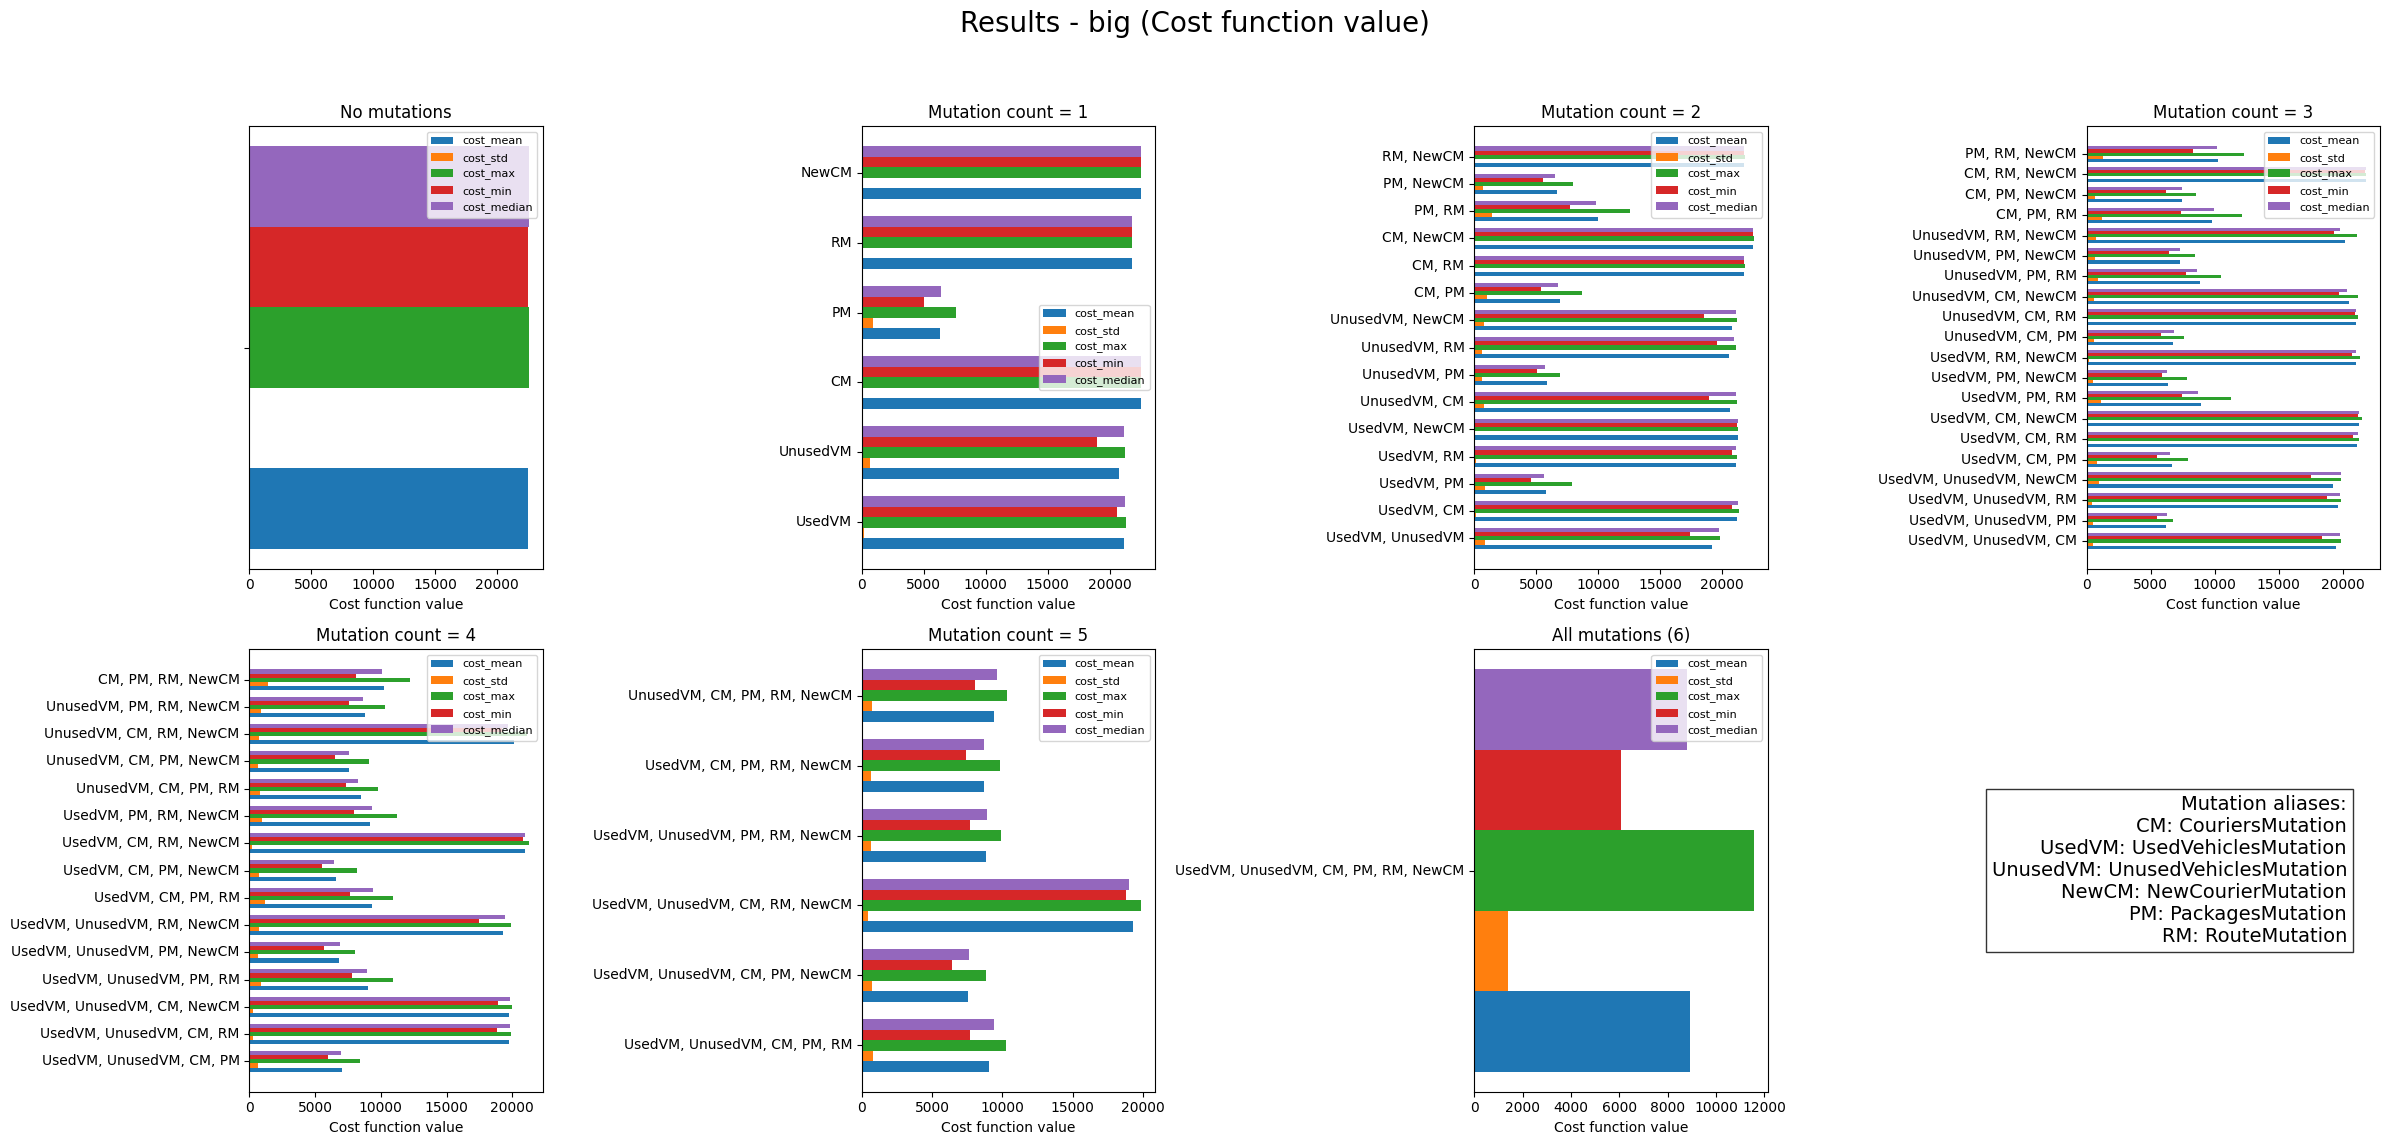

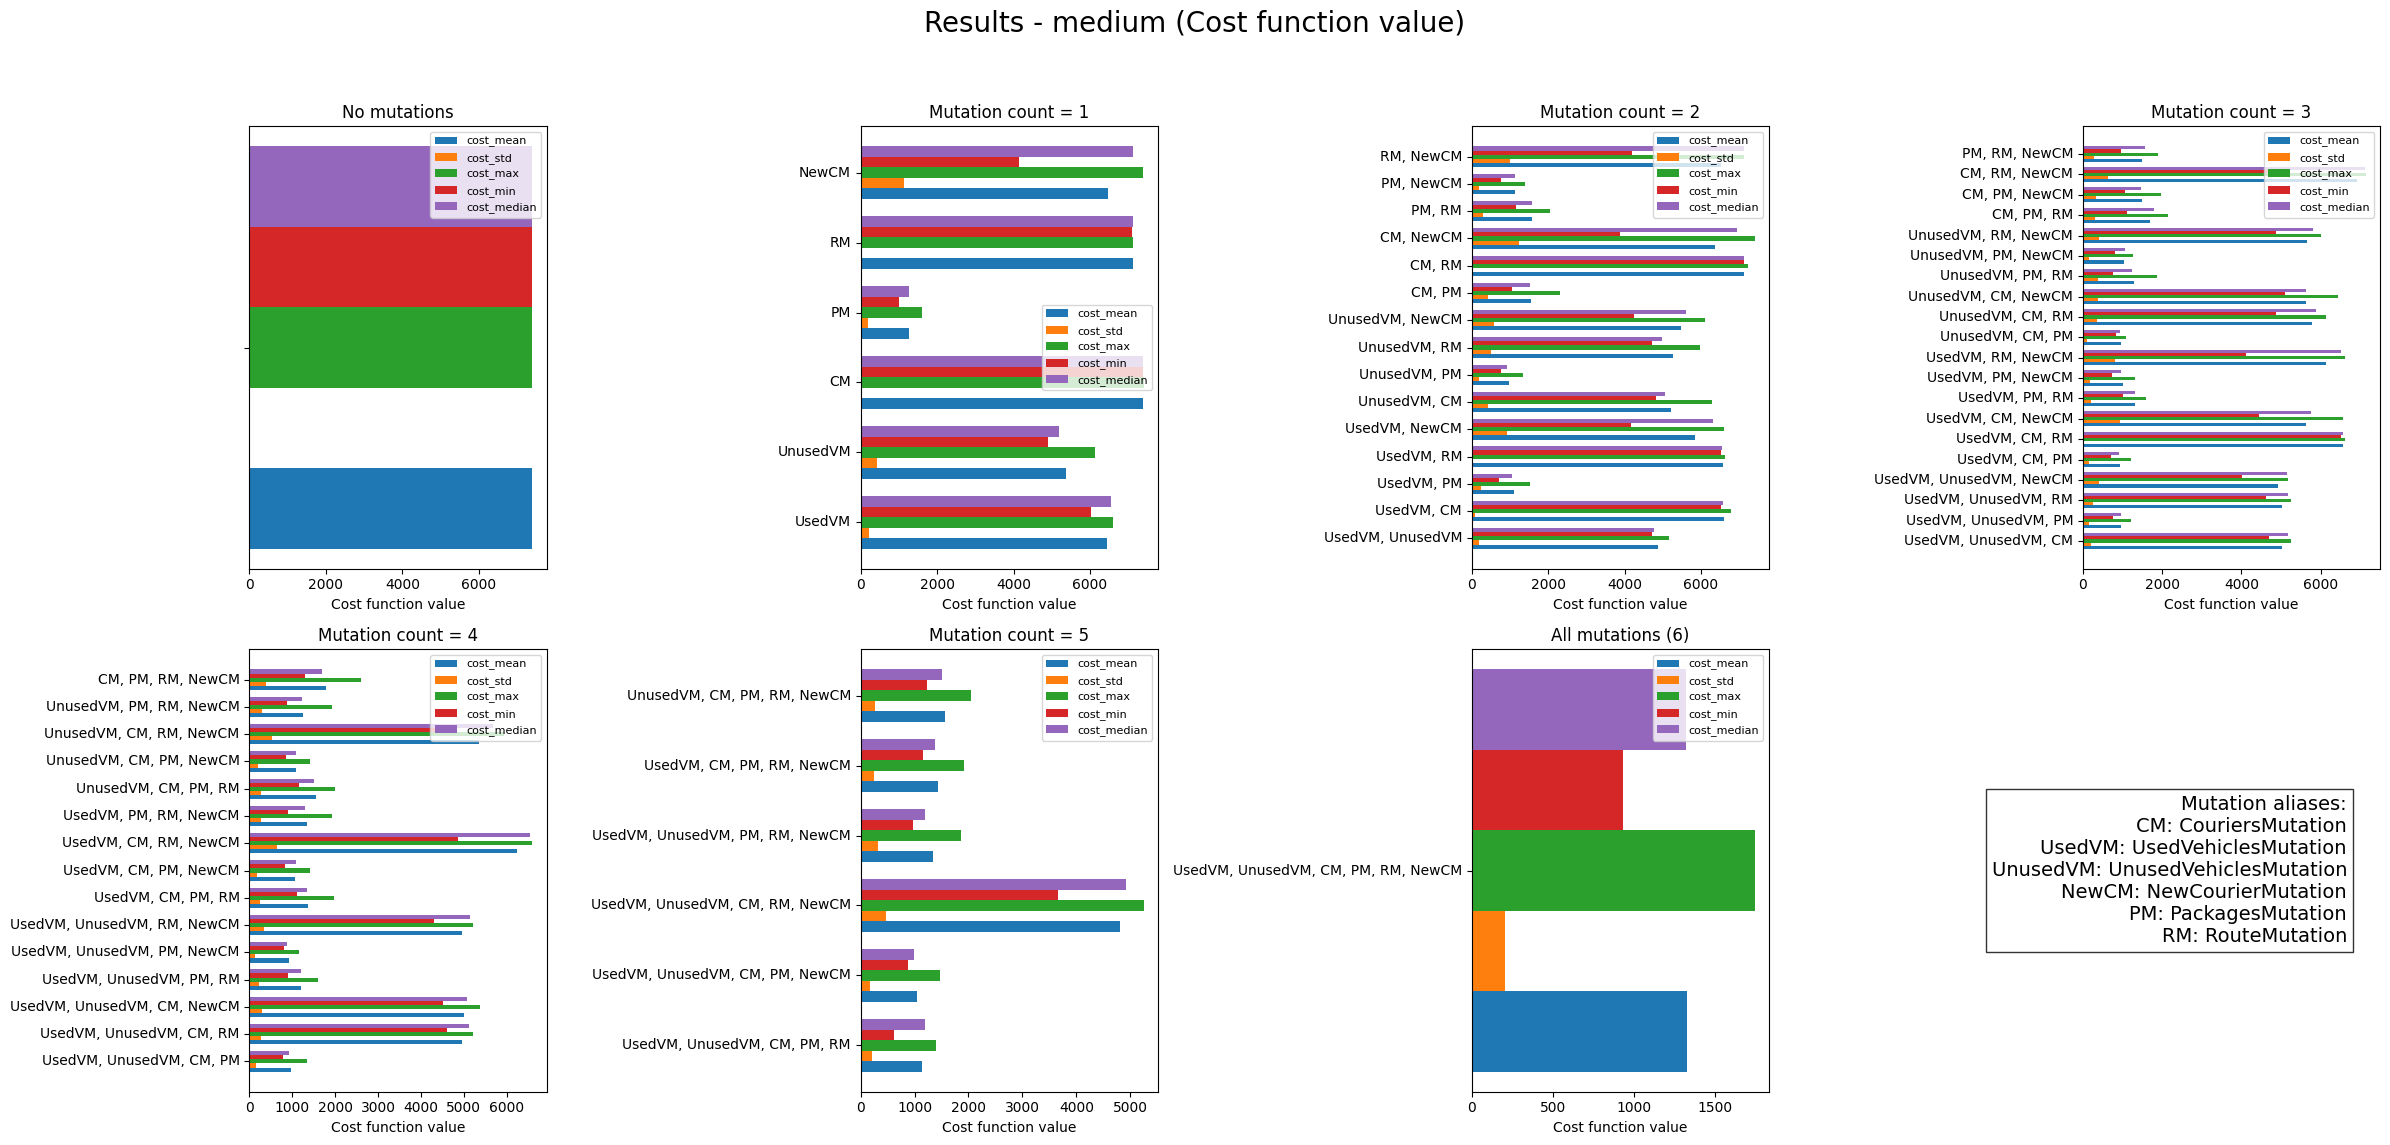

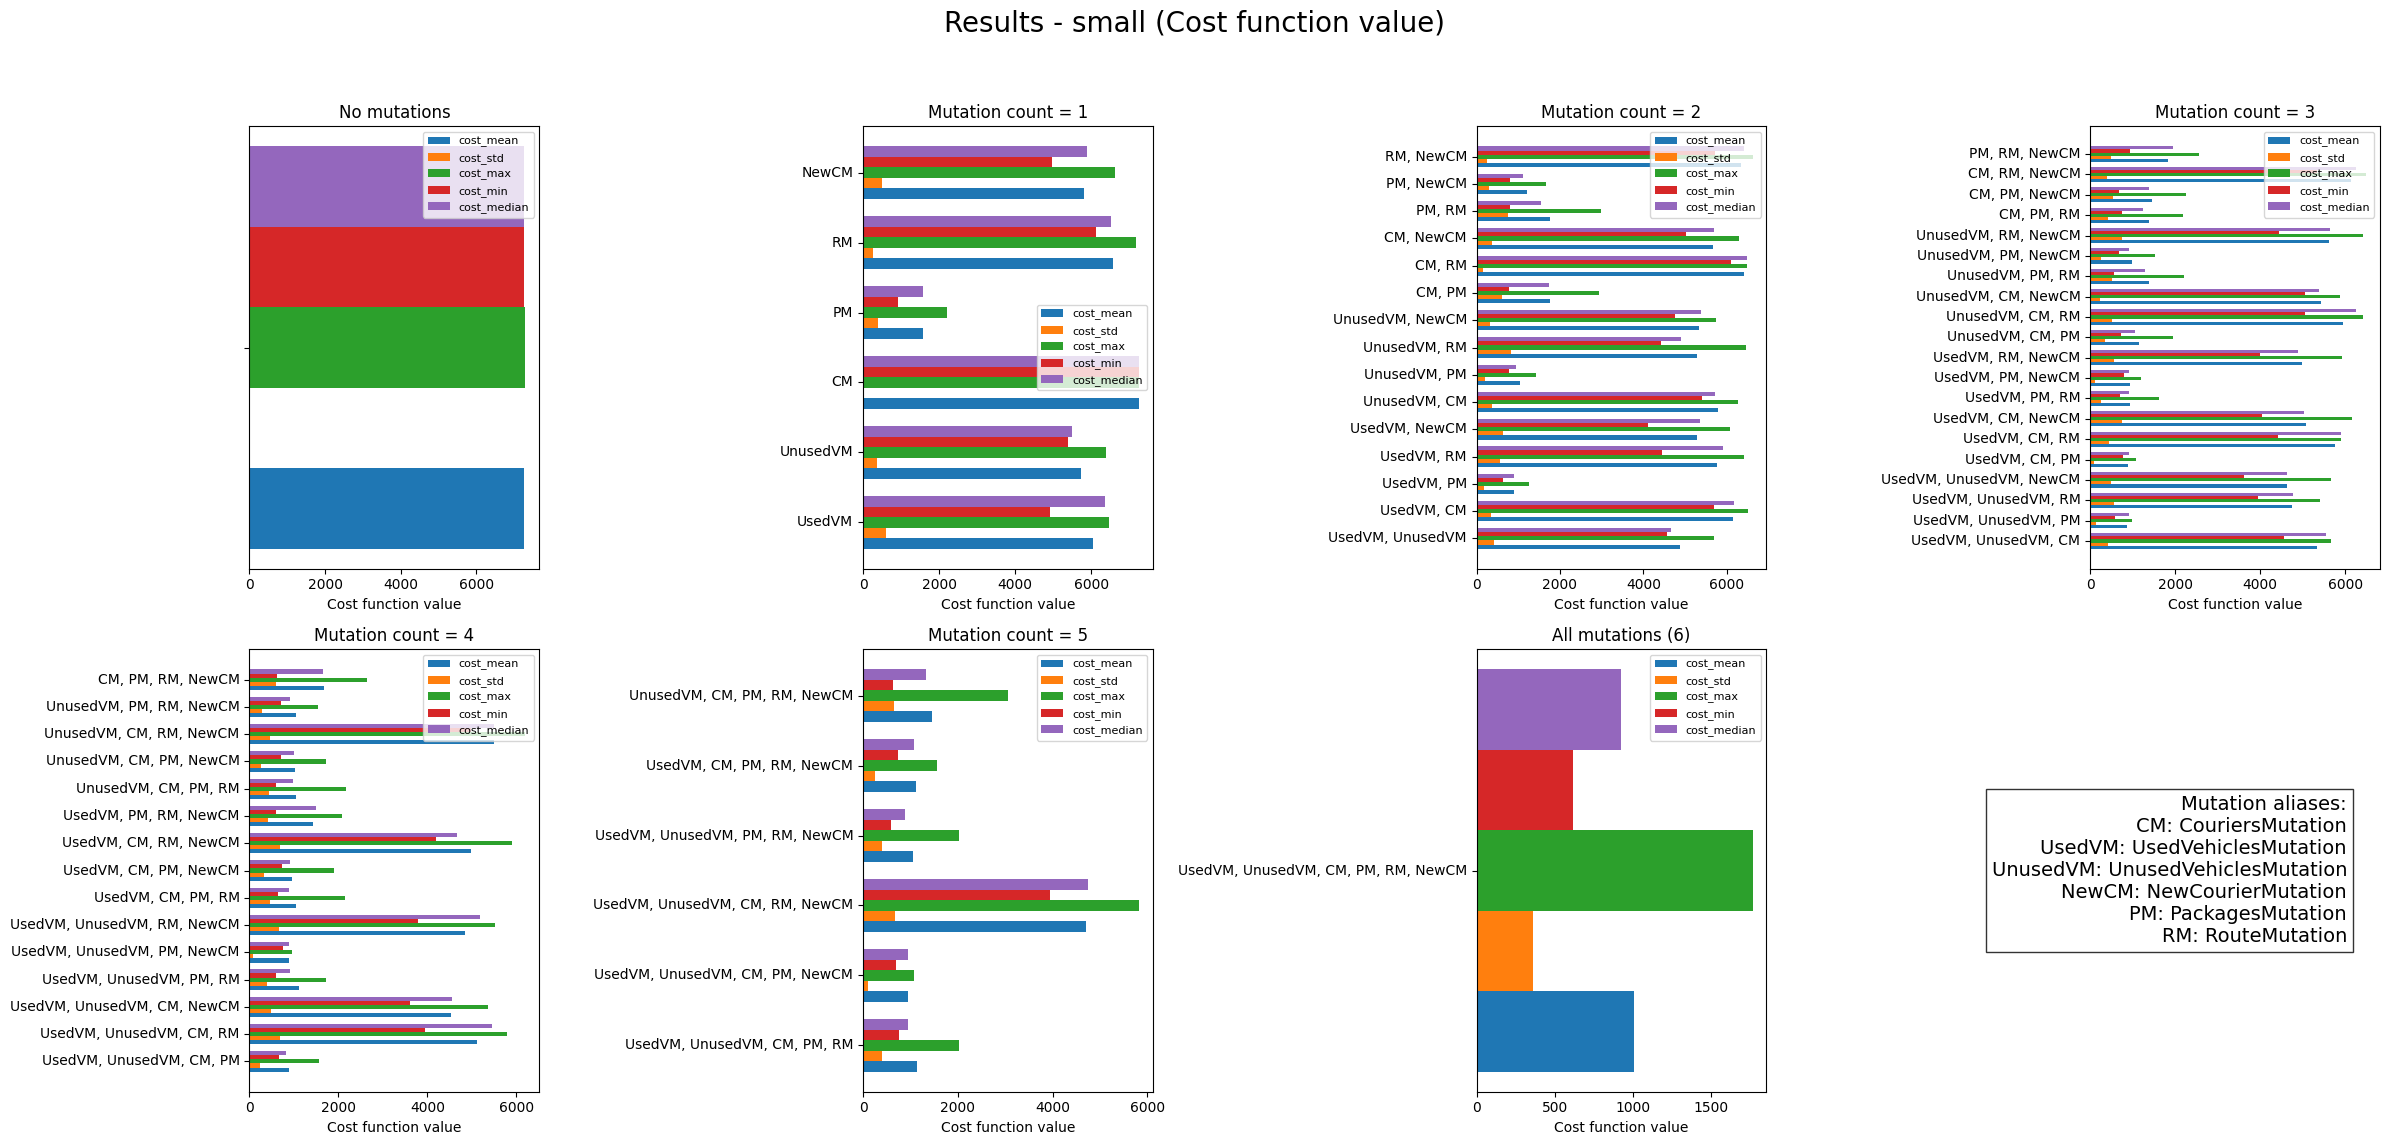

In [40]:
plot_statistics(
    mutation_results_df,
    stat_cols=stat_lists["Cost statistics"],
    xlabel="Cost function value",
)

#### Iteration statistics

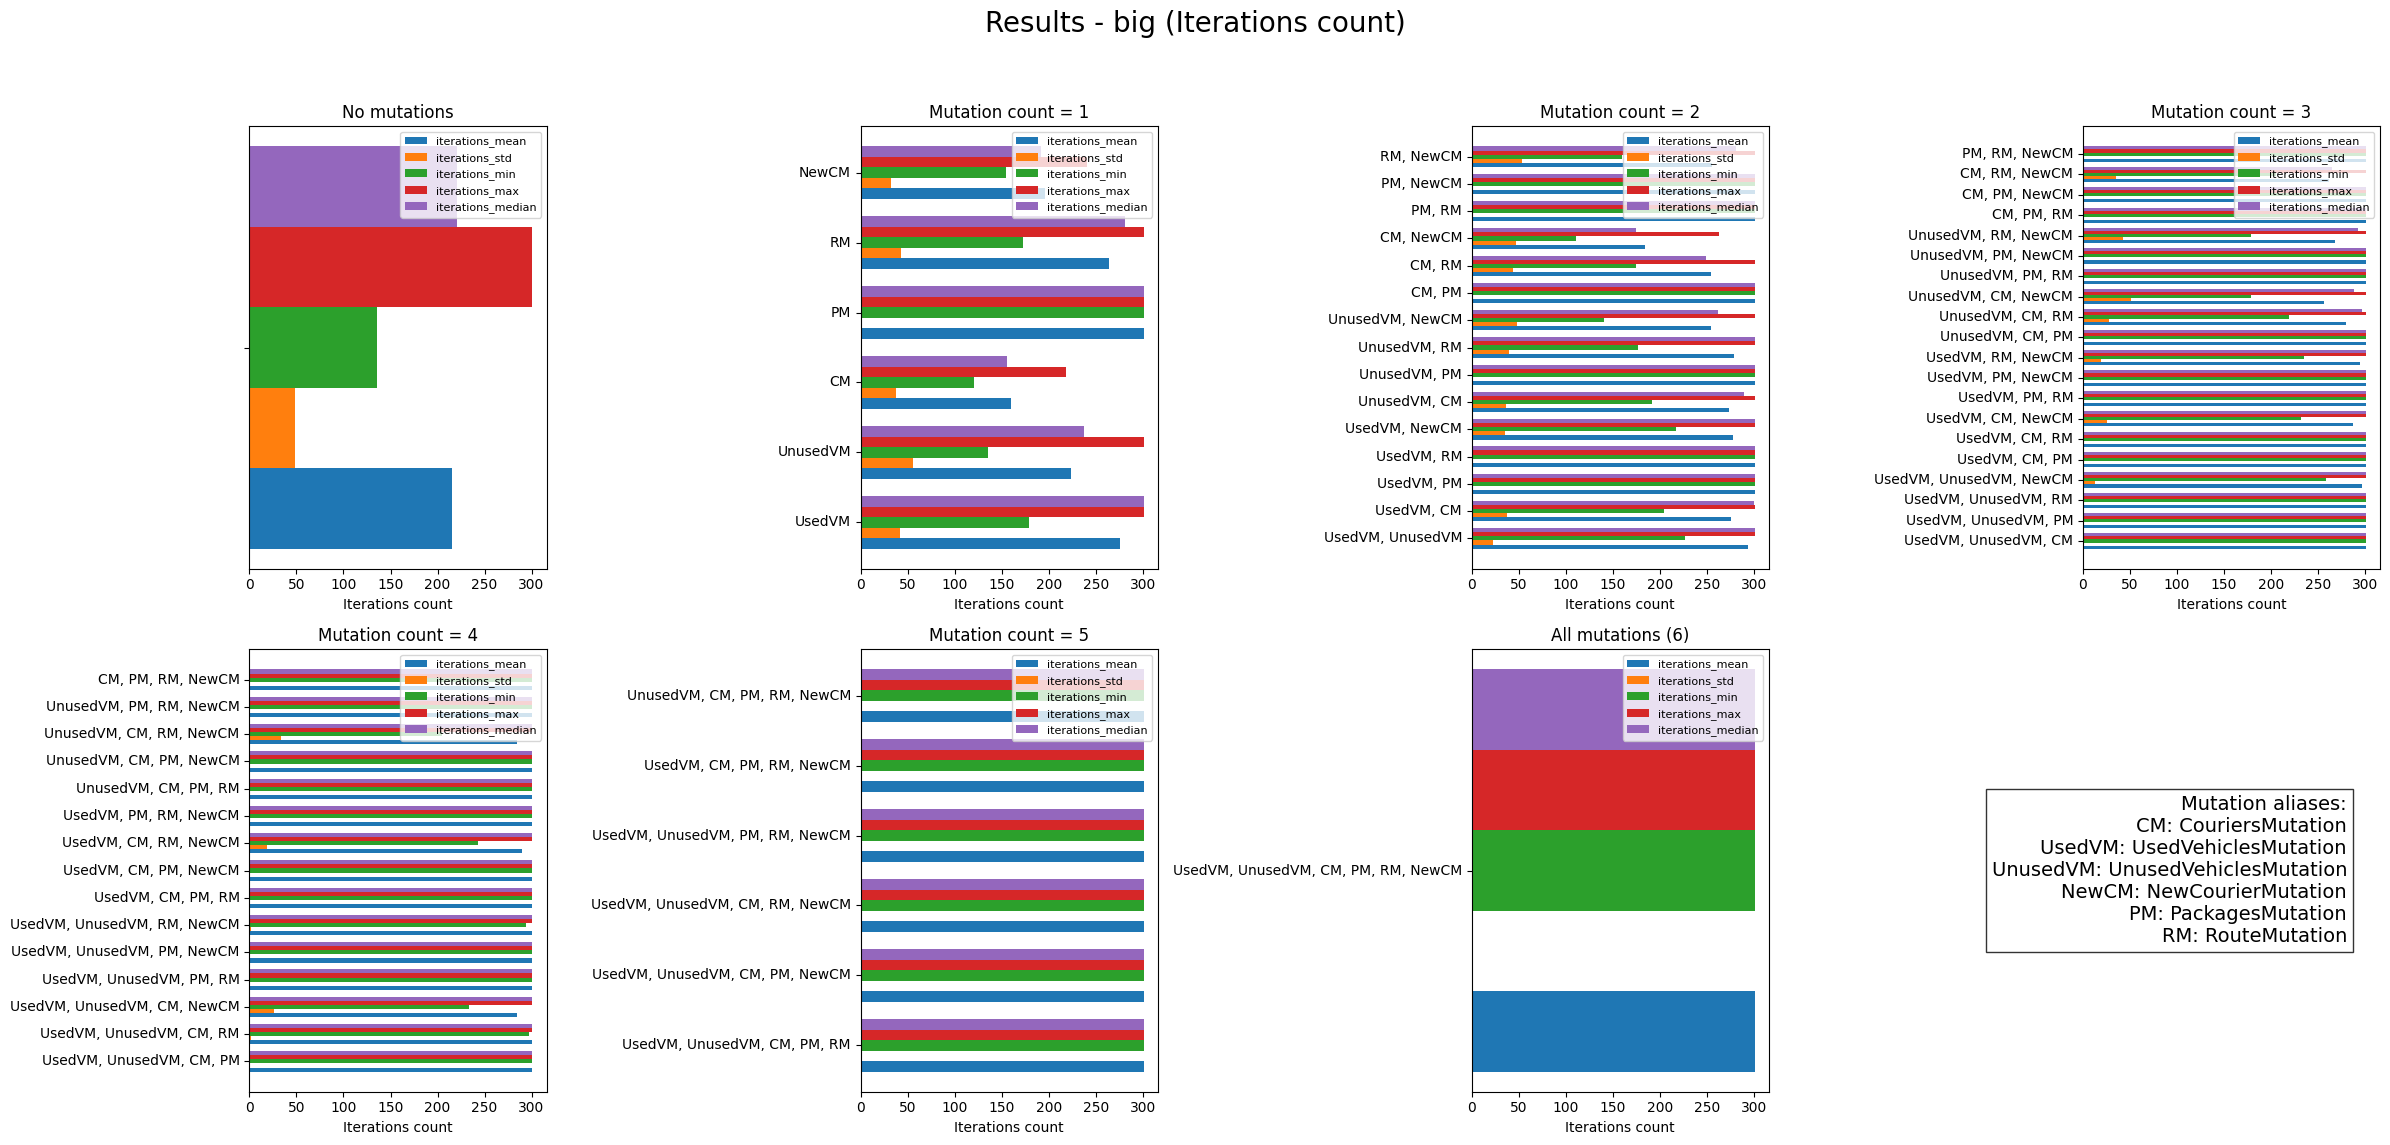

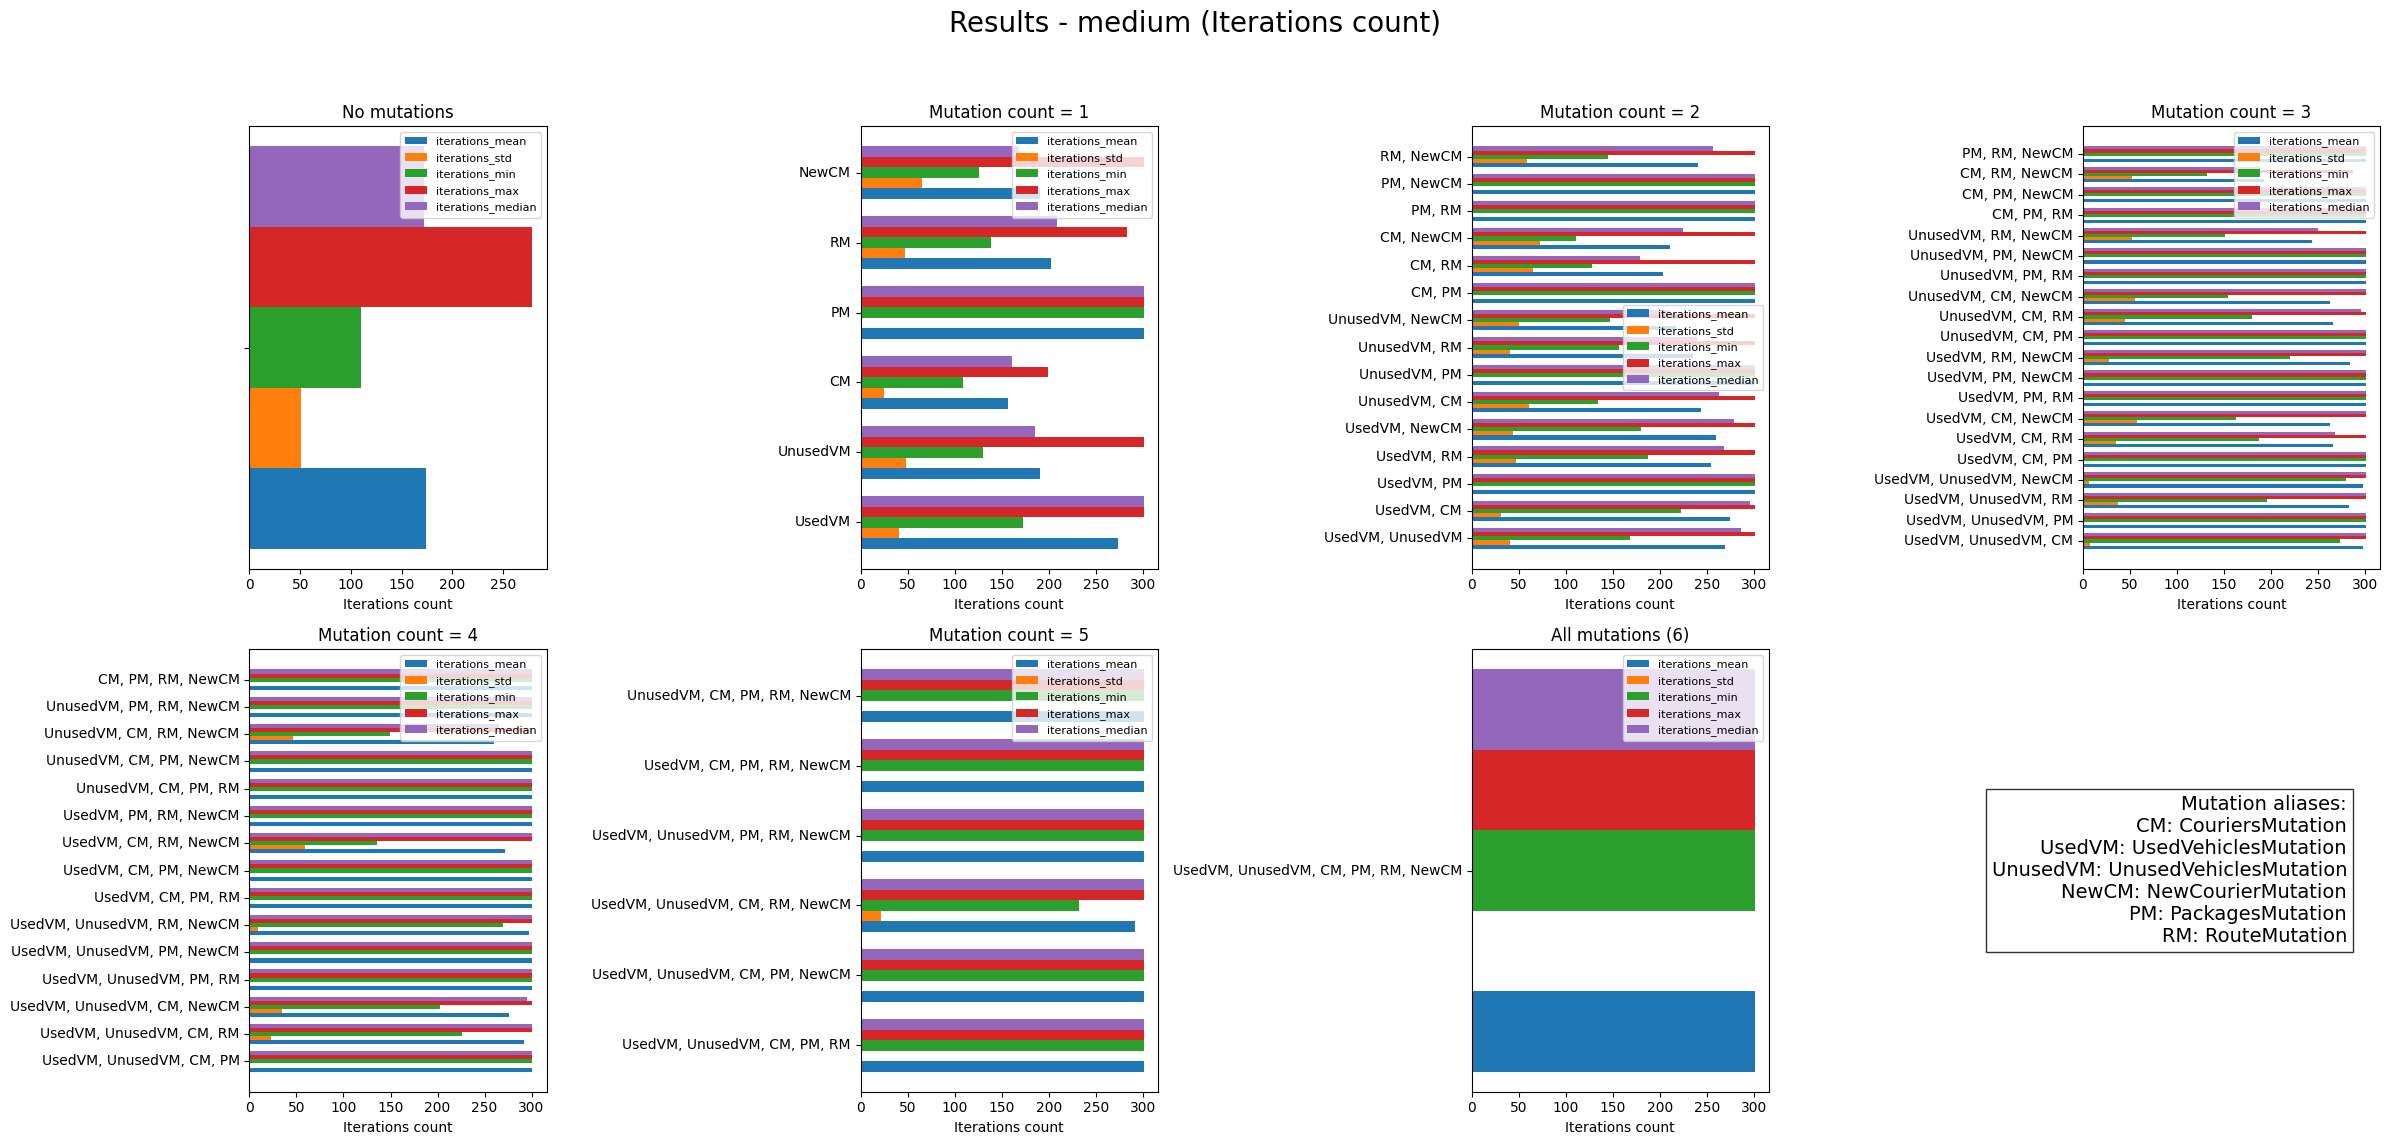

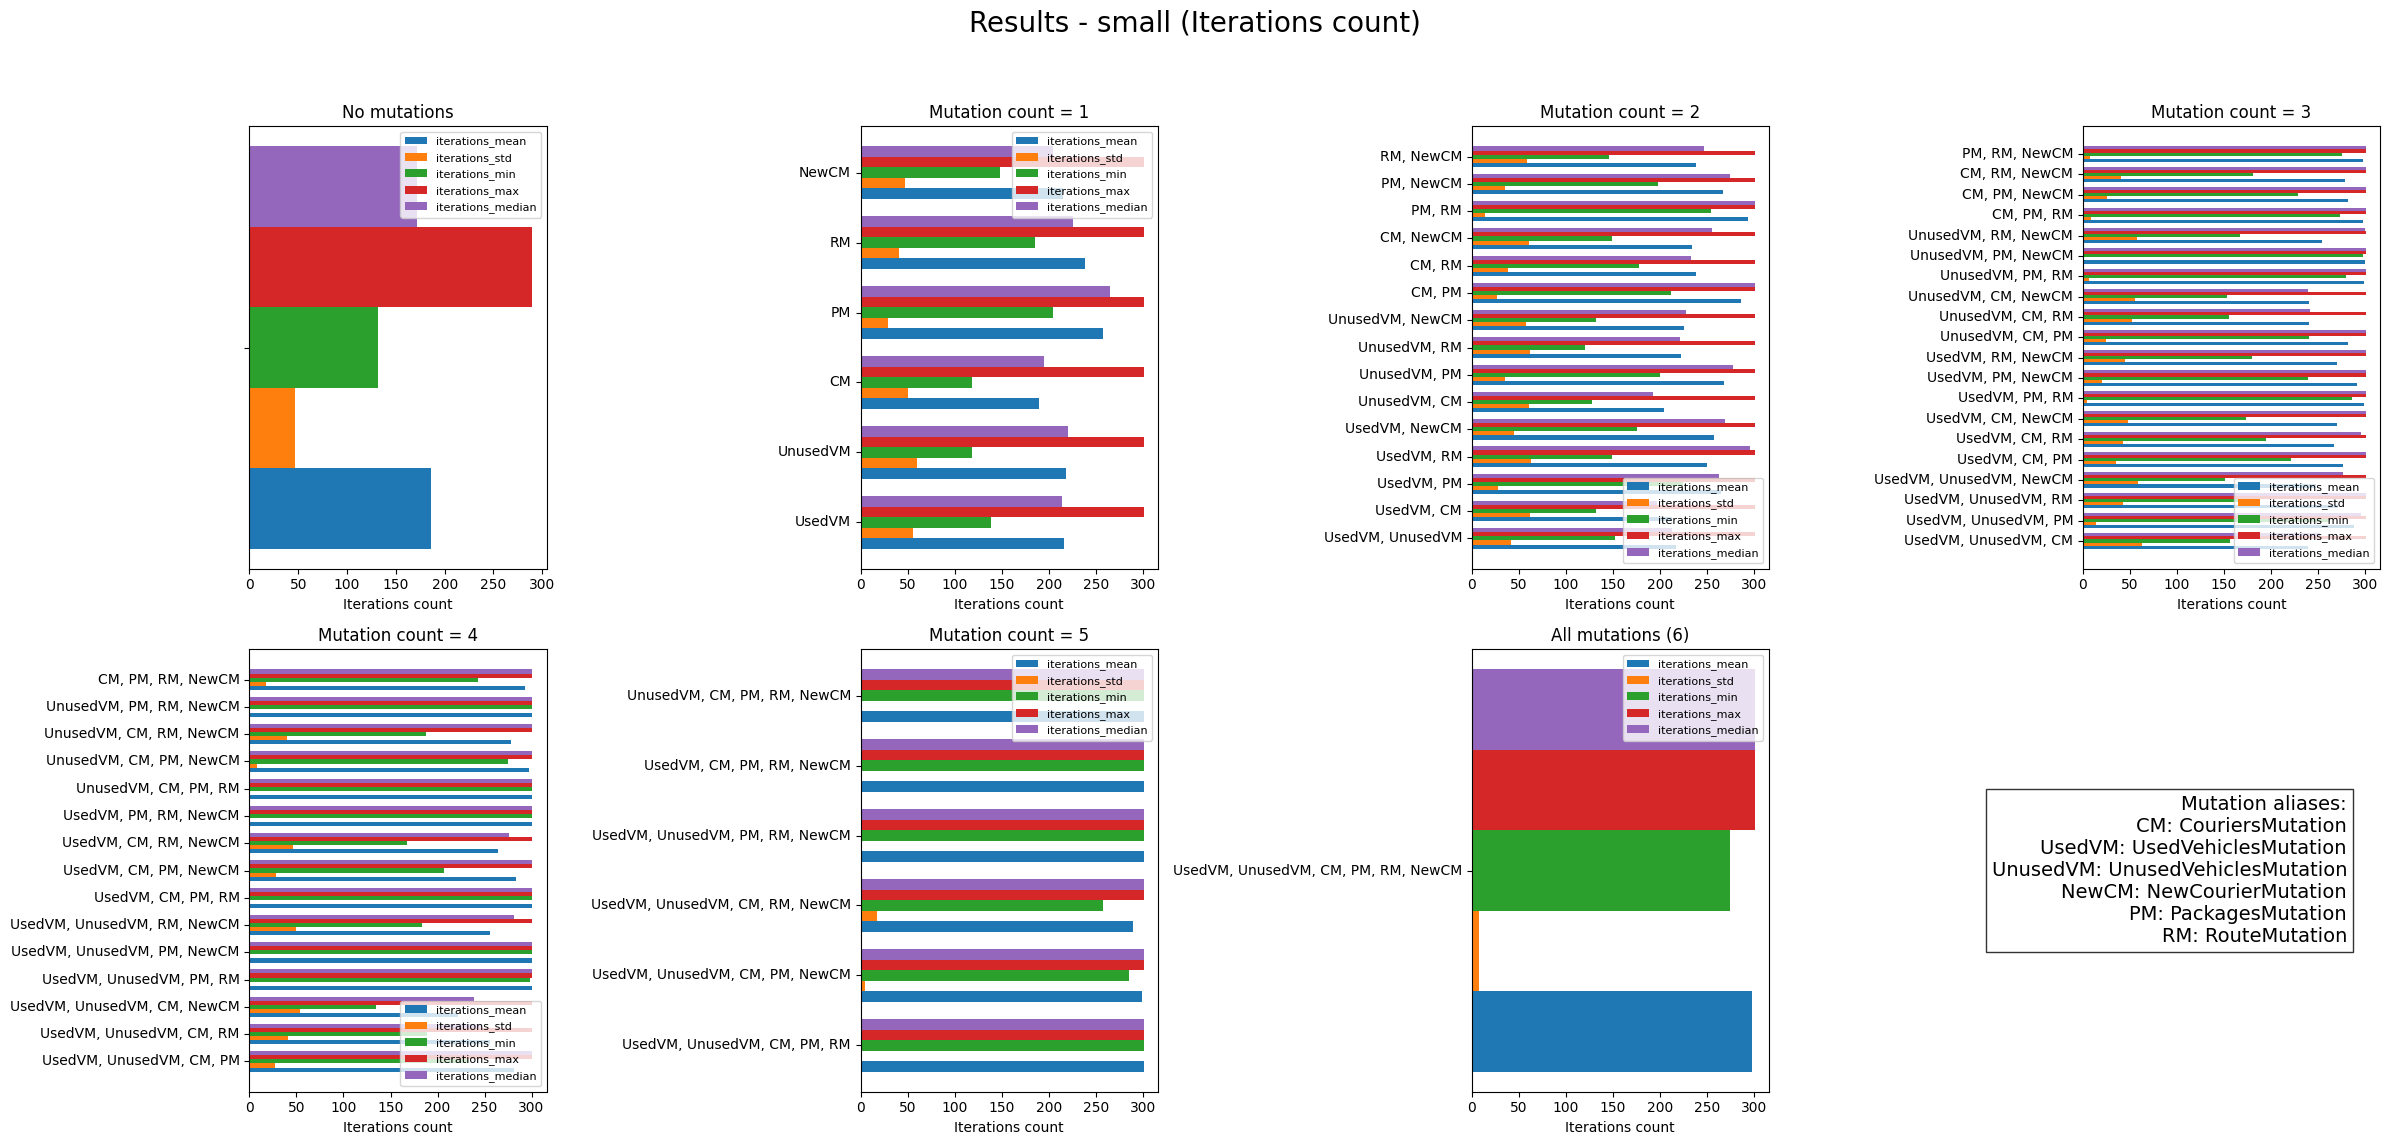

In [41]:
plot_statistics(
    mutation_results_df,
    stat_cols=stat_lists["Iterations statistics"],
    xlabel="Iterations count",
)

#### Time statistics

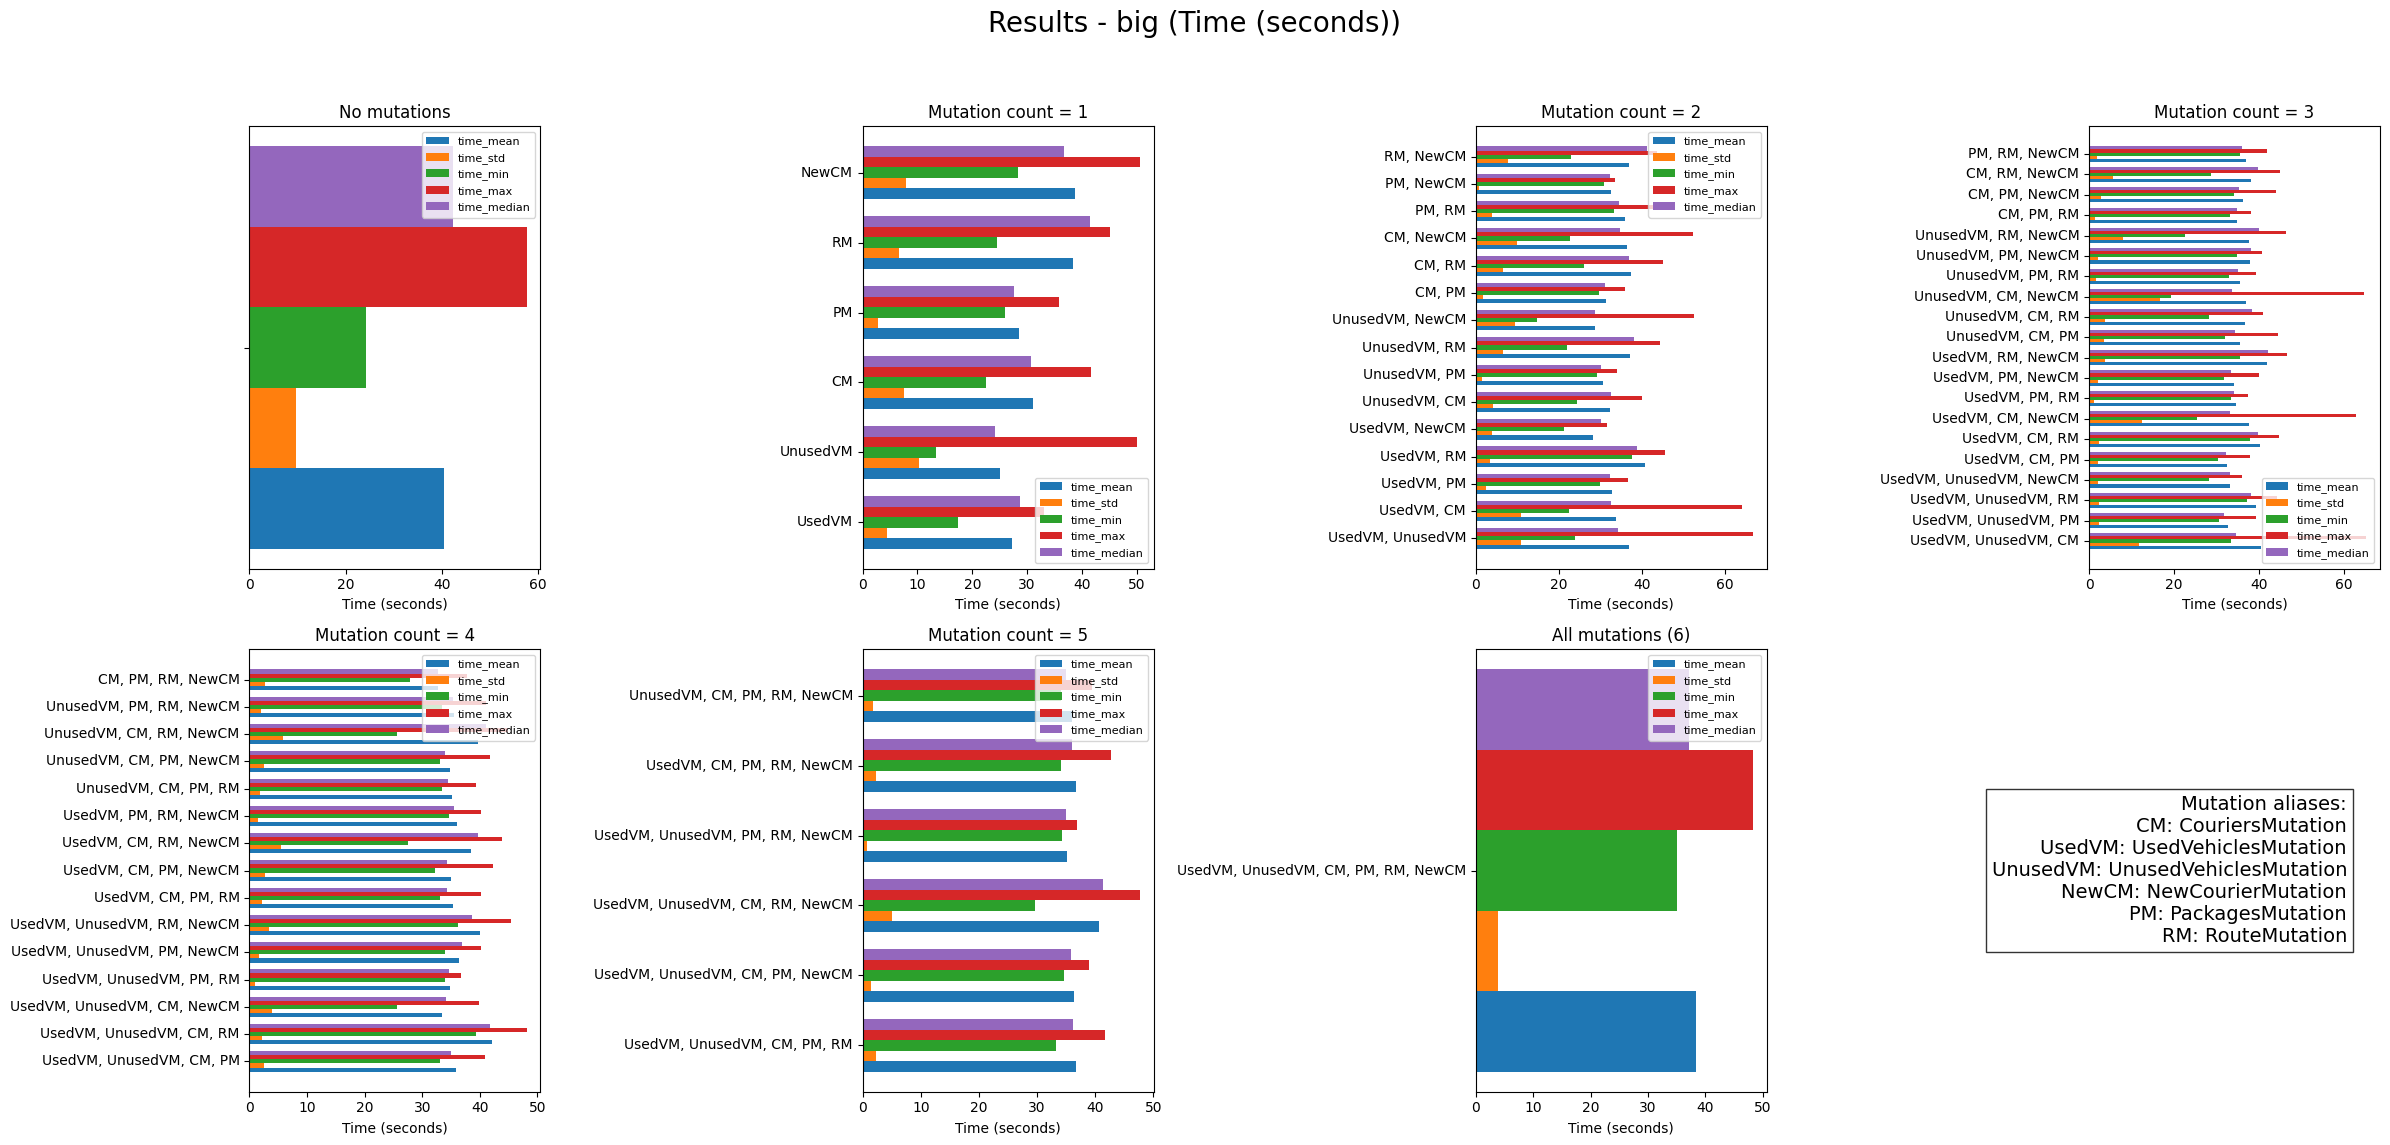

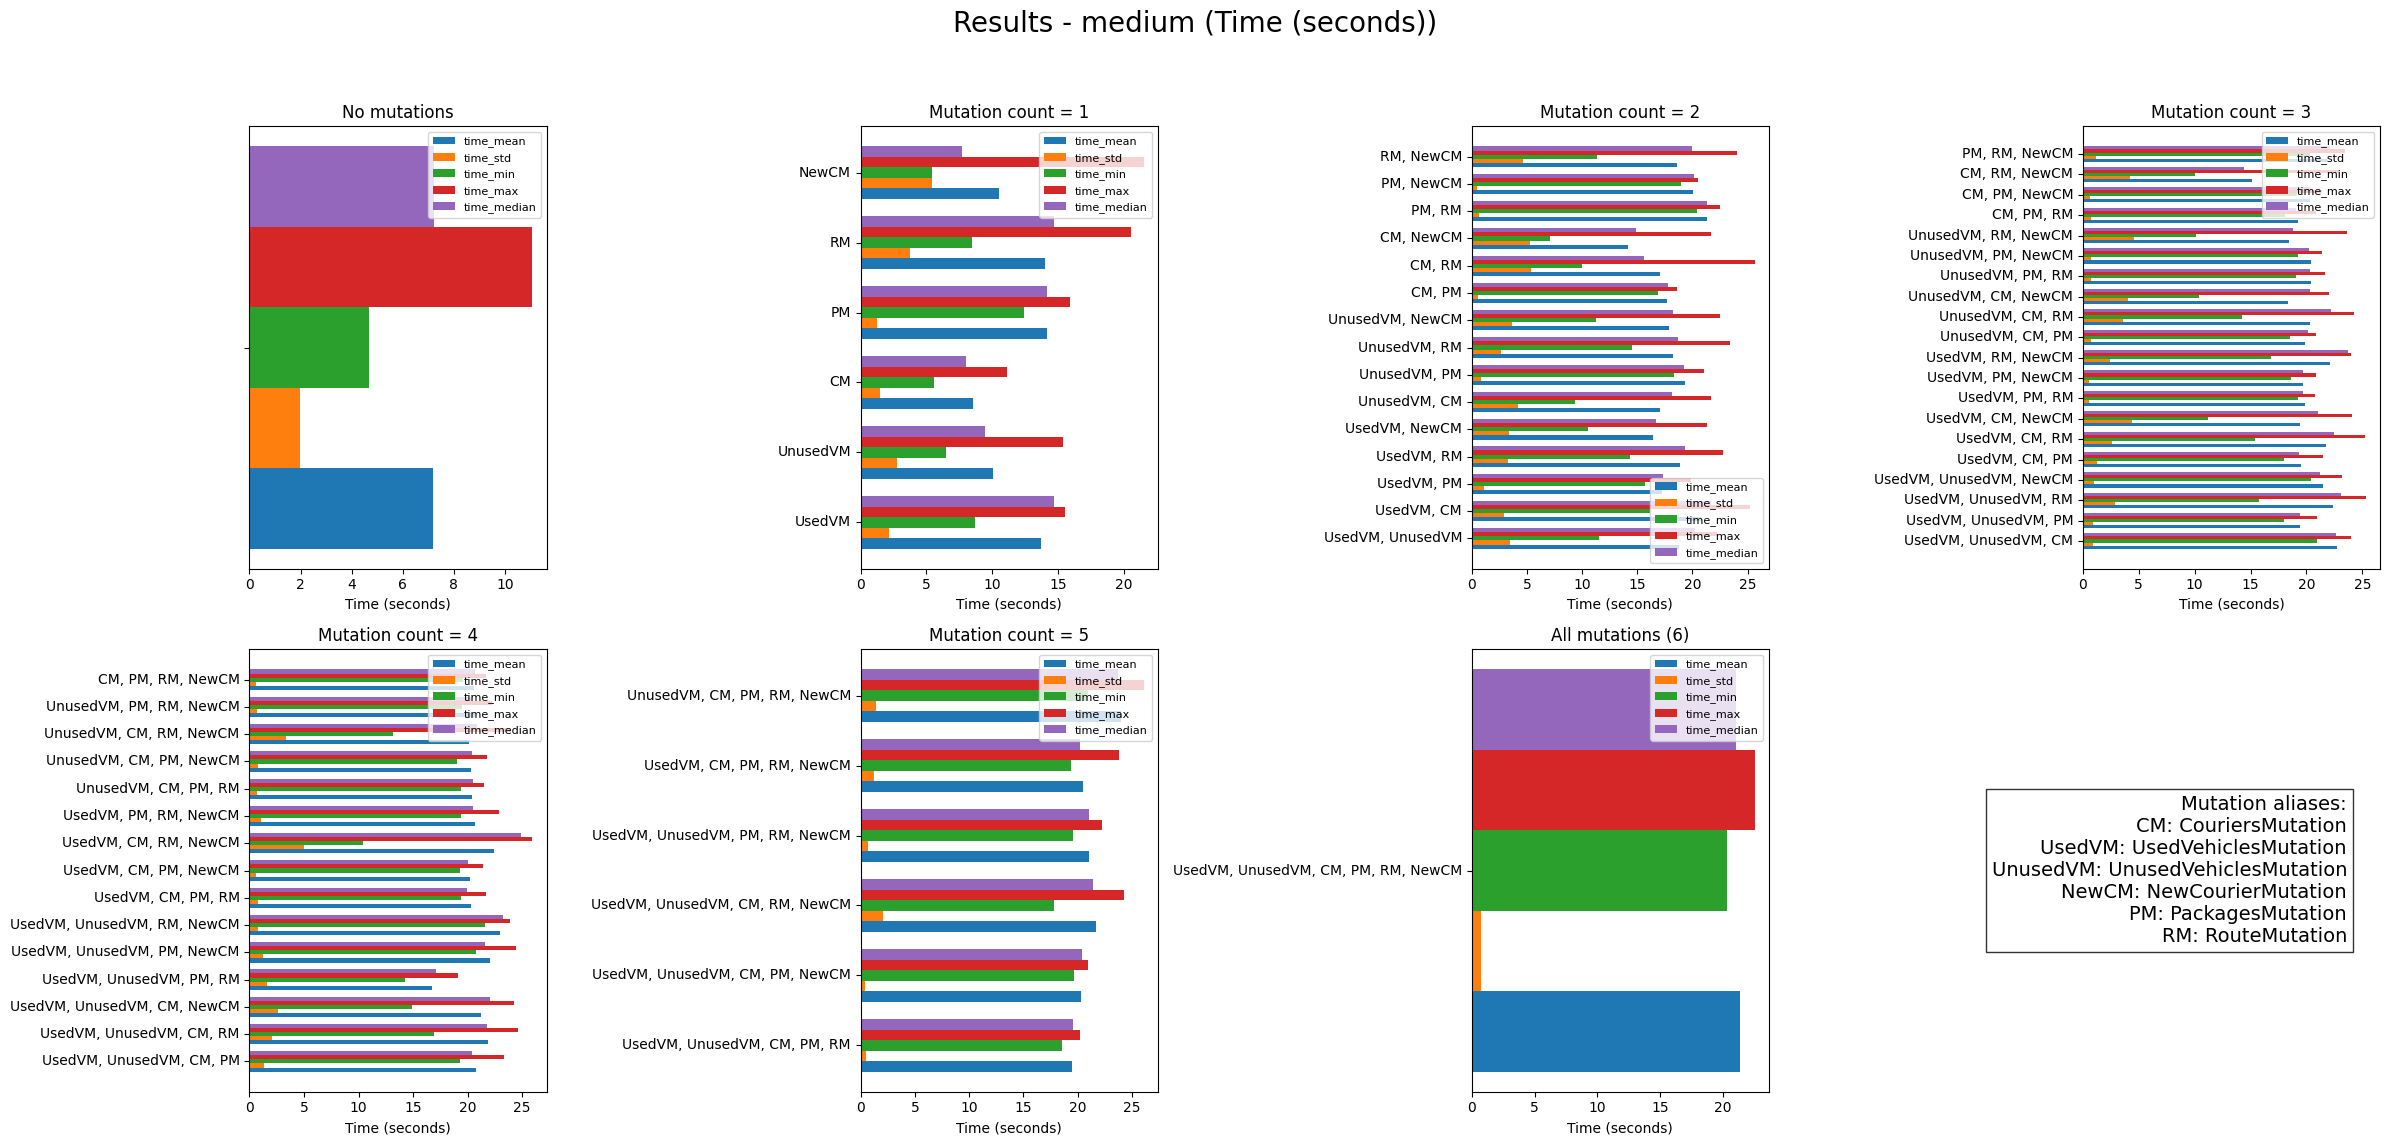

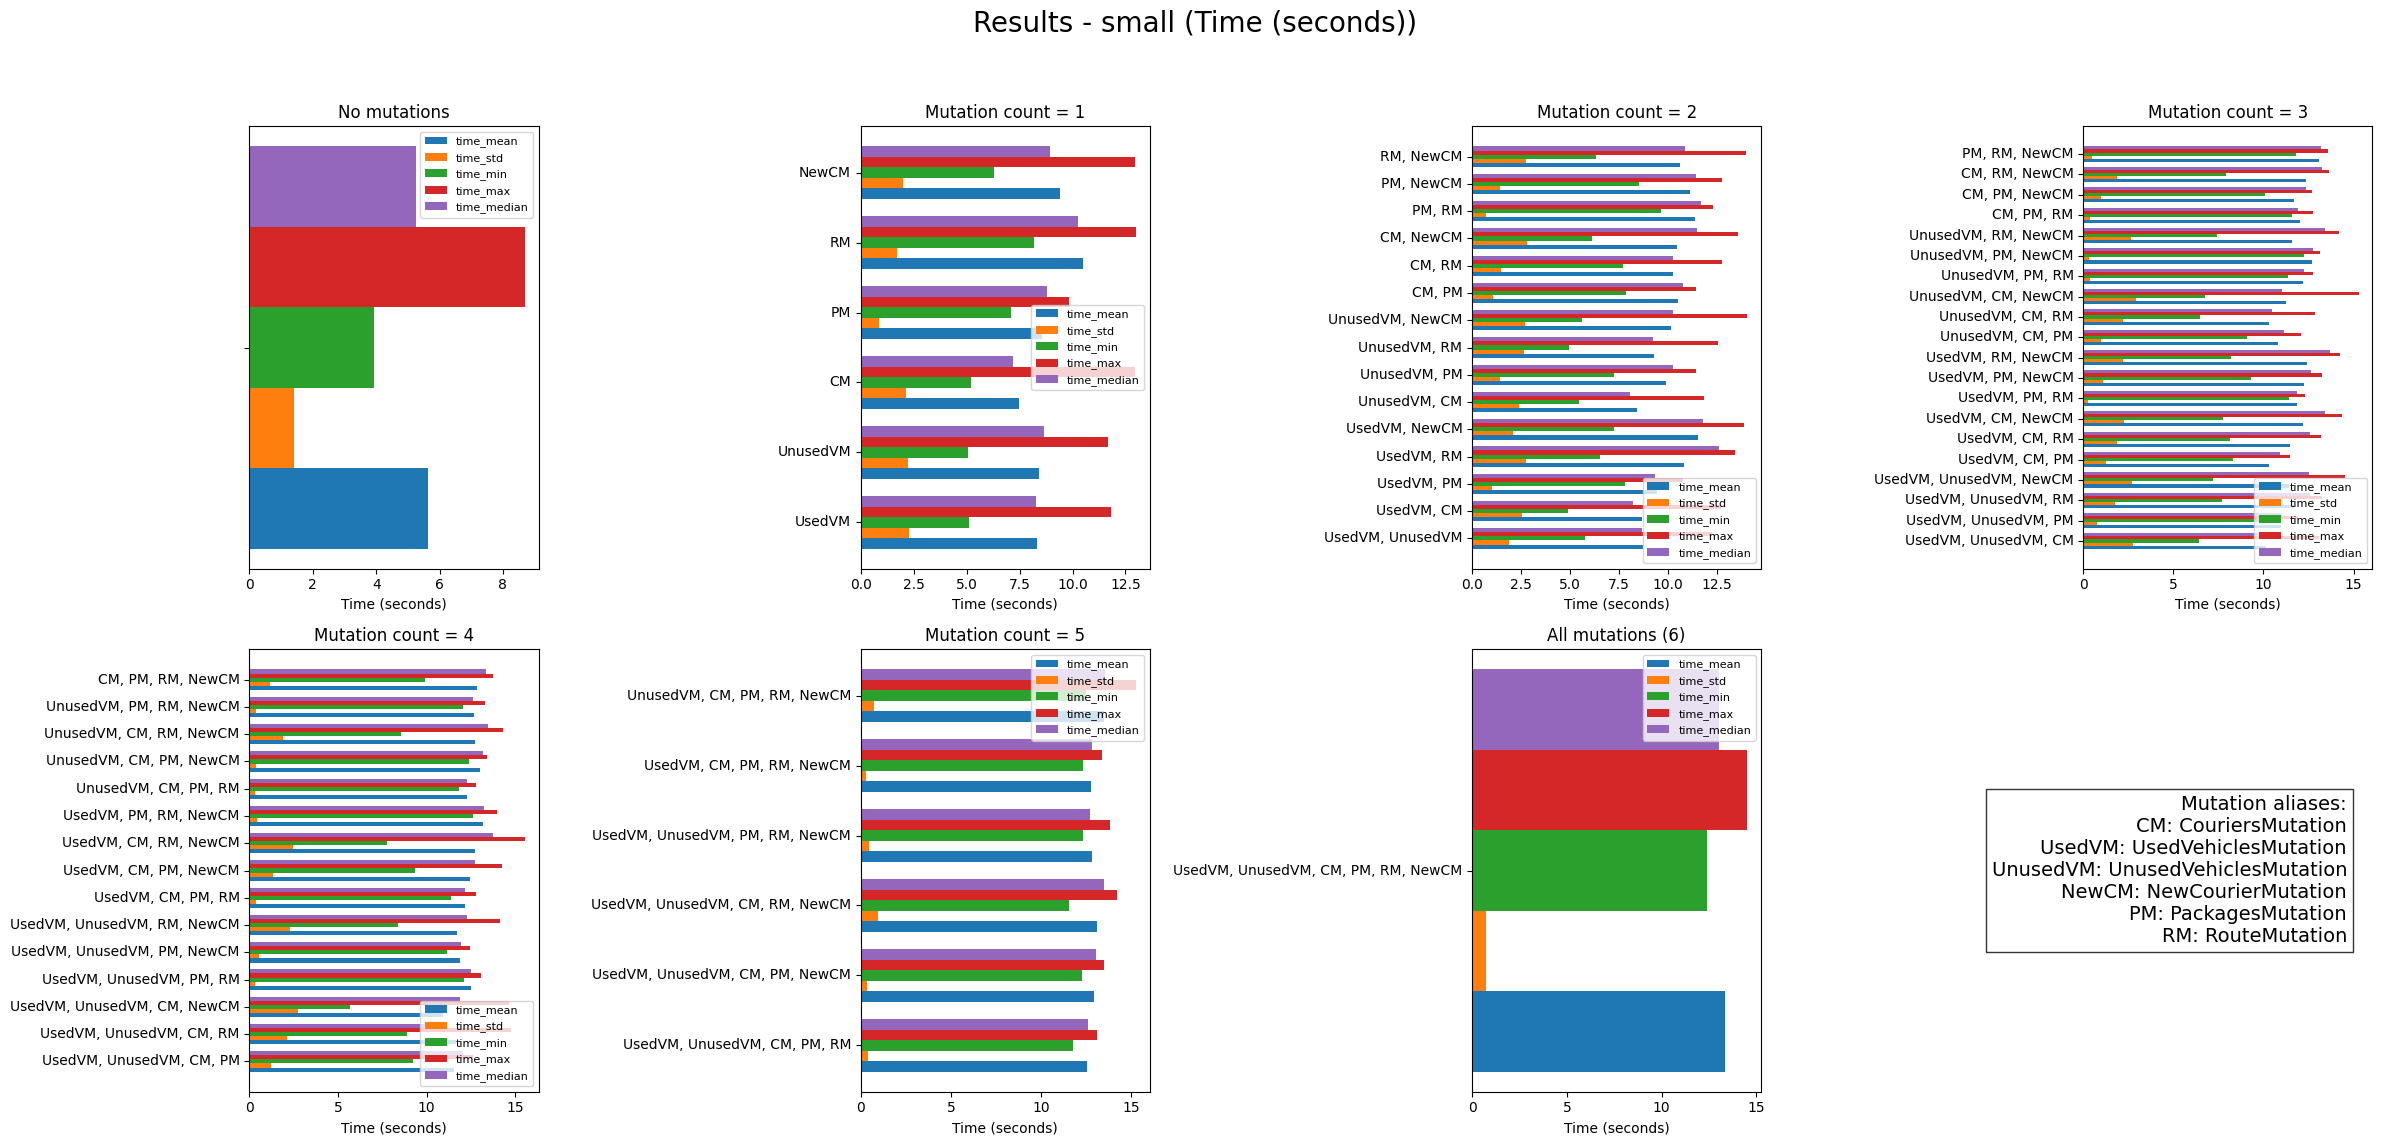

In [42]:
plot_statistics(
    mutation_results_df,
    stat_cols=stat_lists["Time statistics"],
    xlabel="Time (seconds)",
)

#### Cost function evaluation count statistics

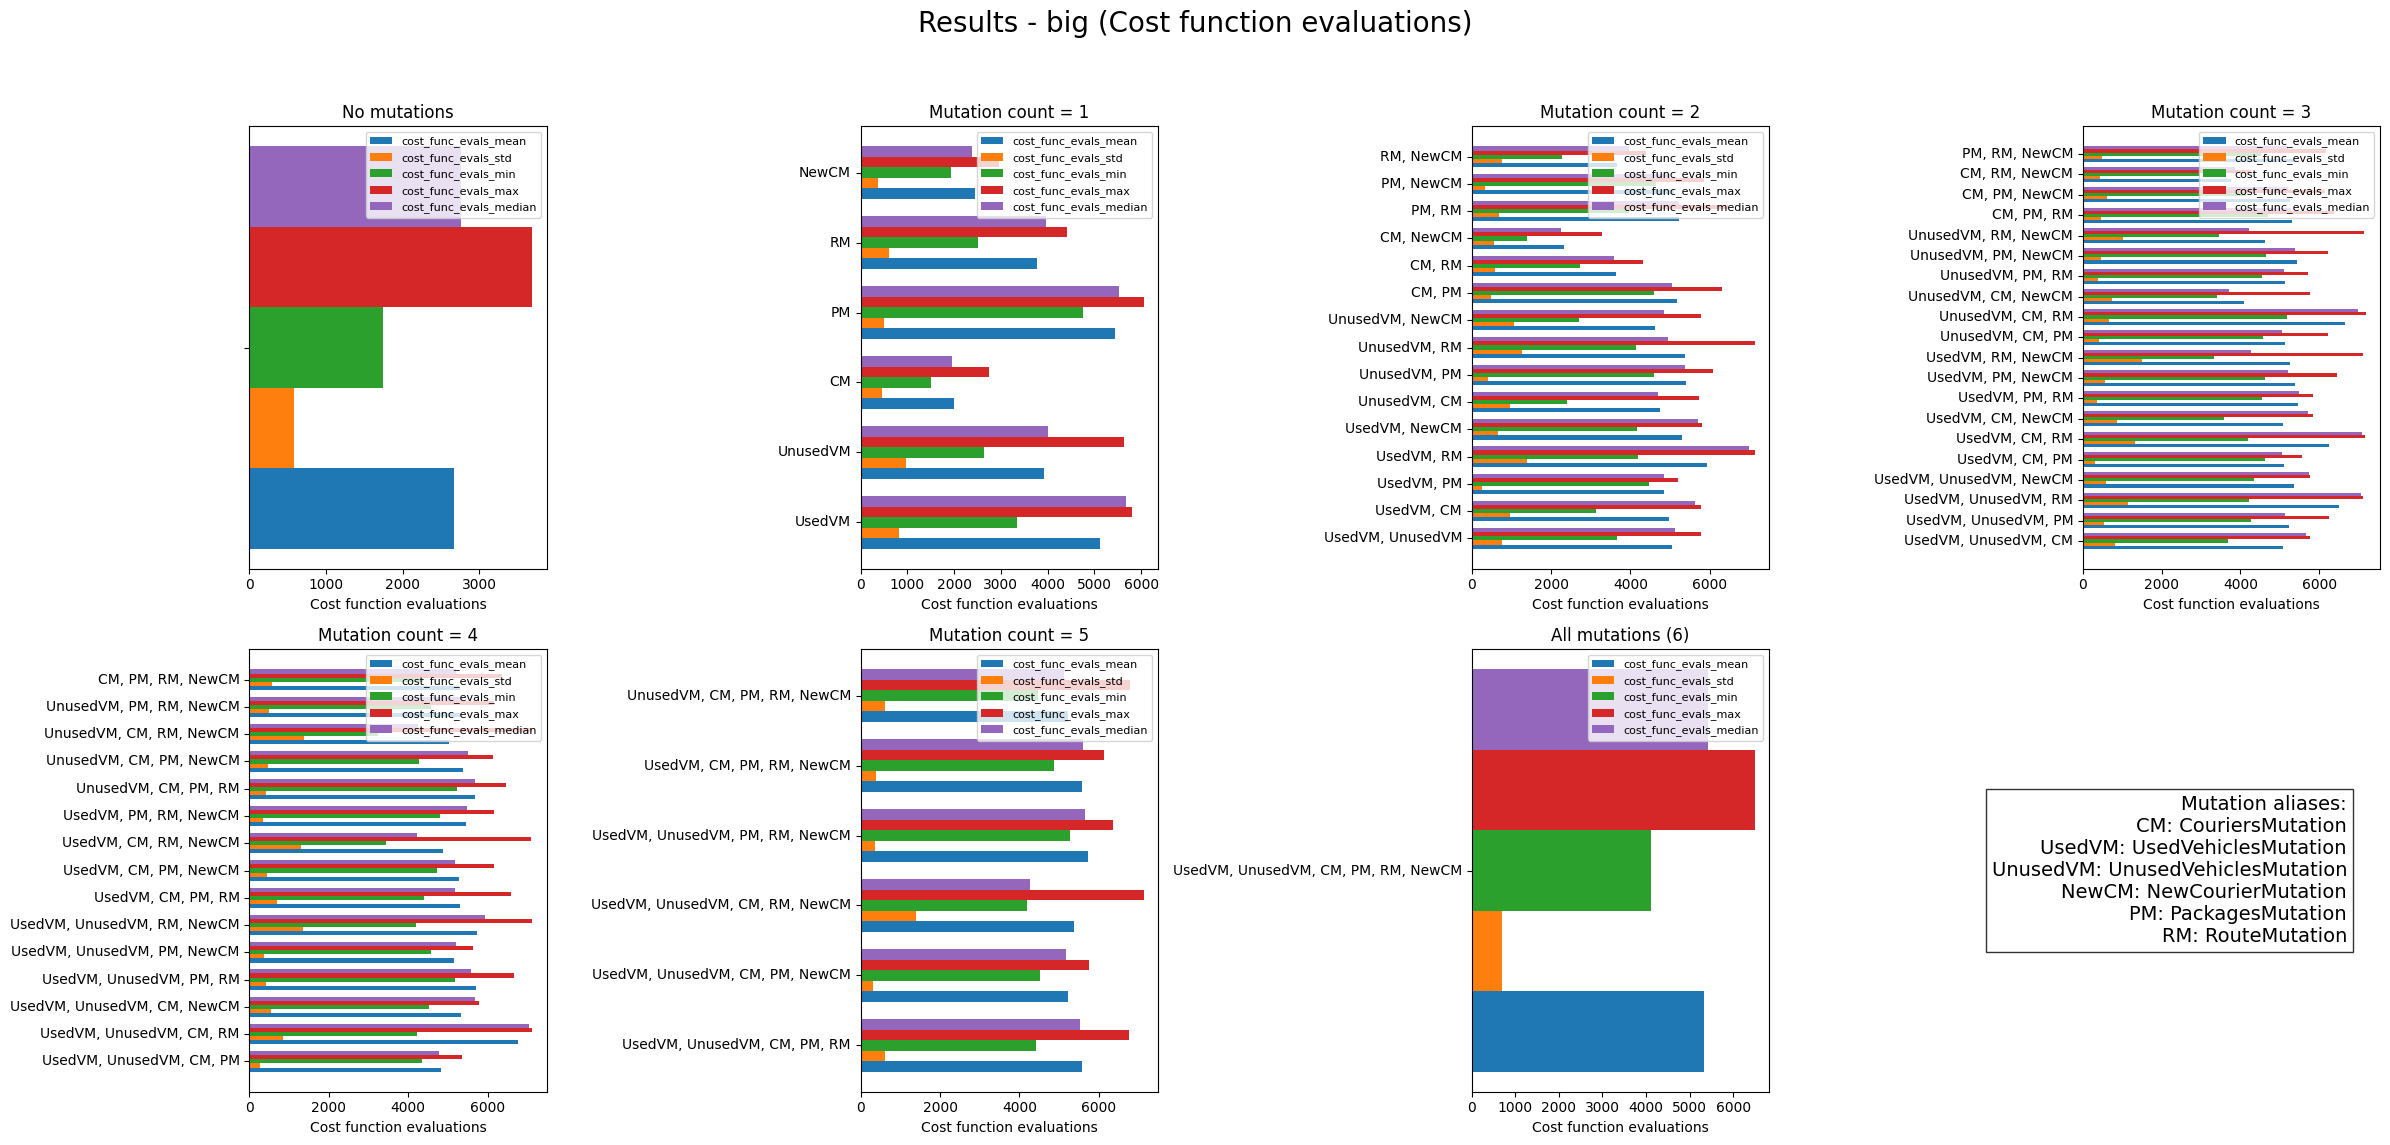

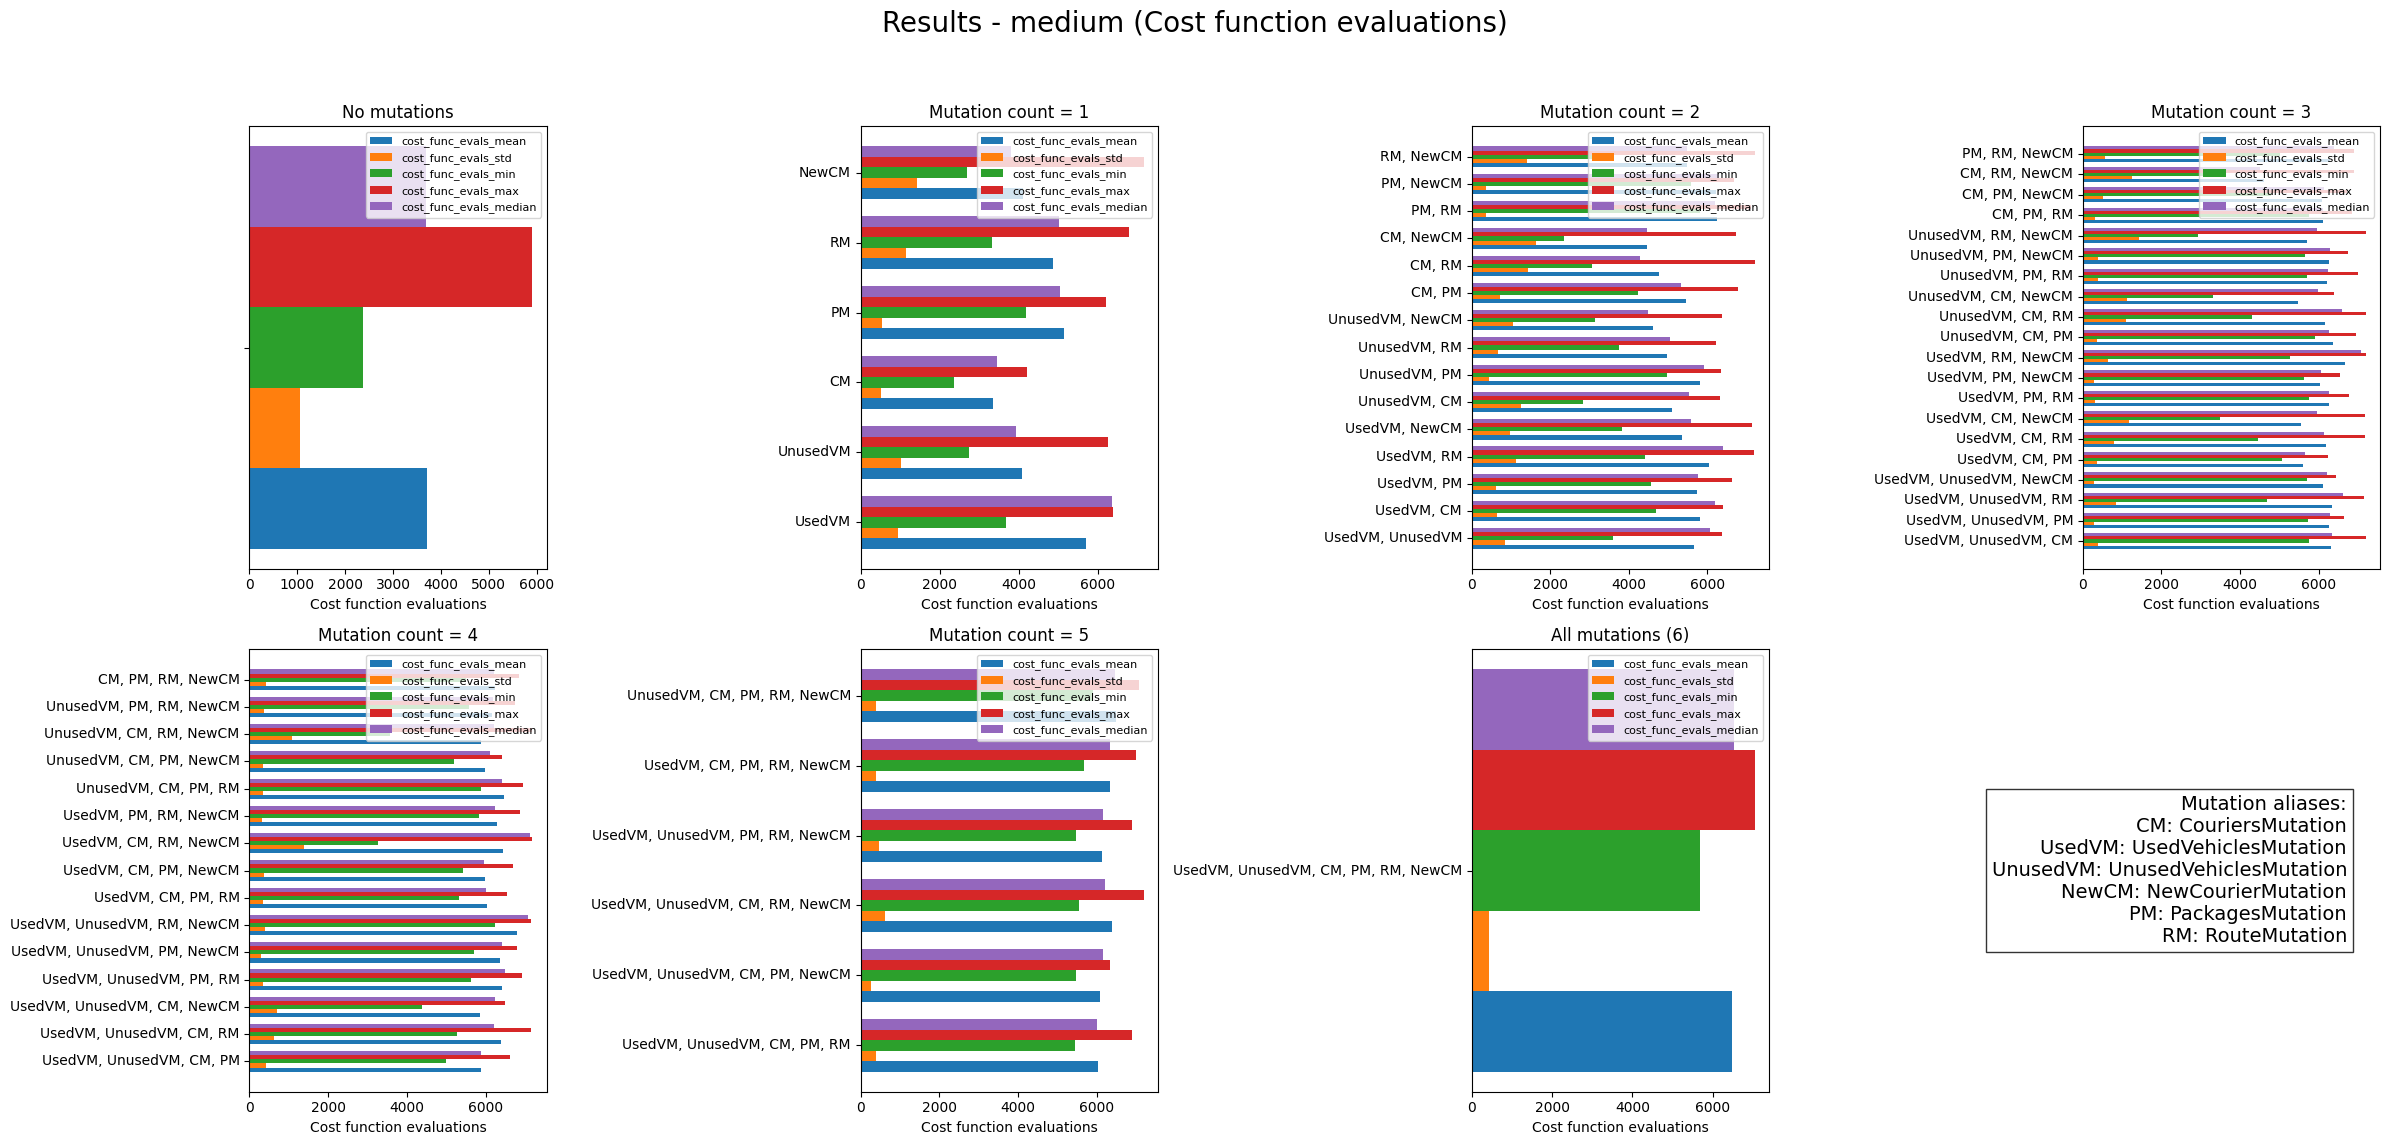

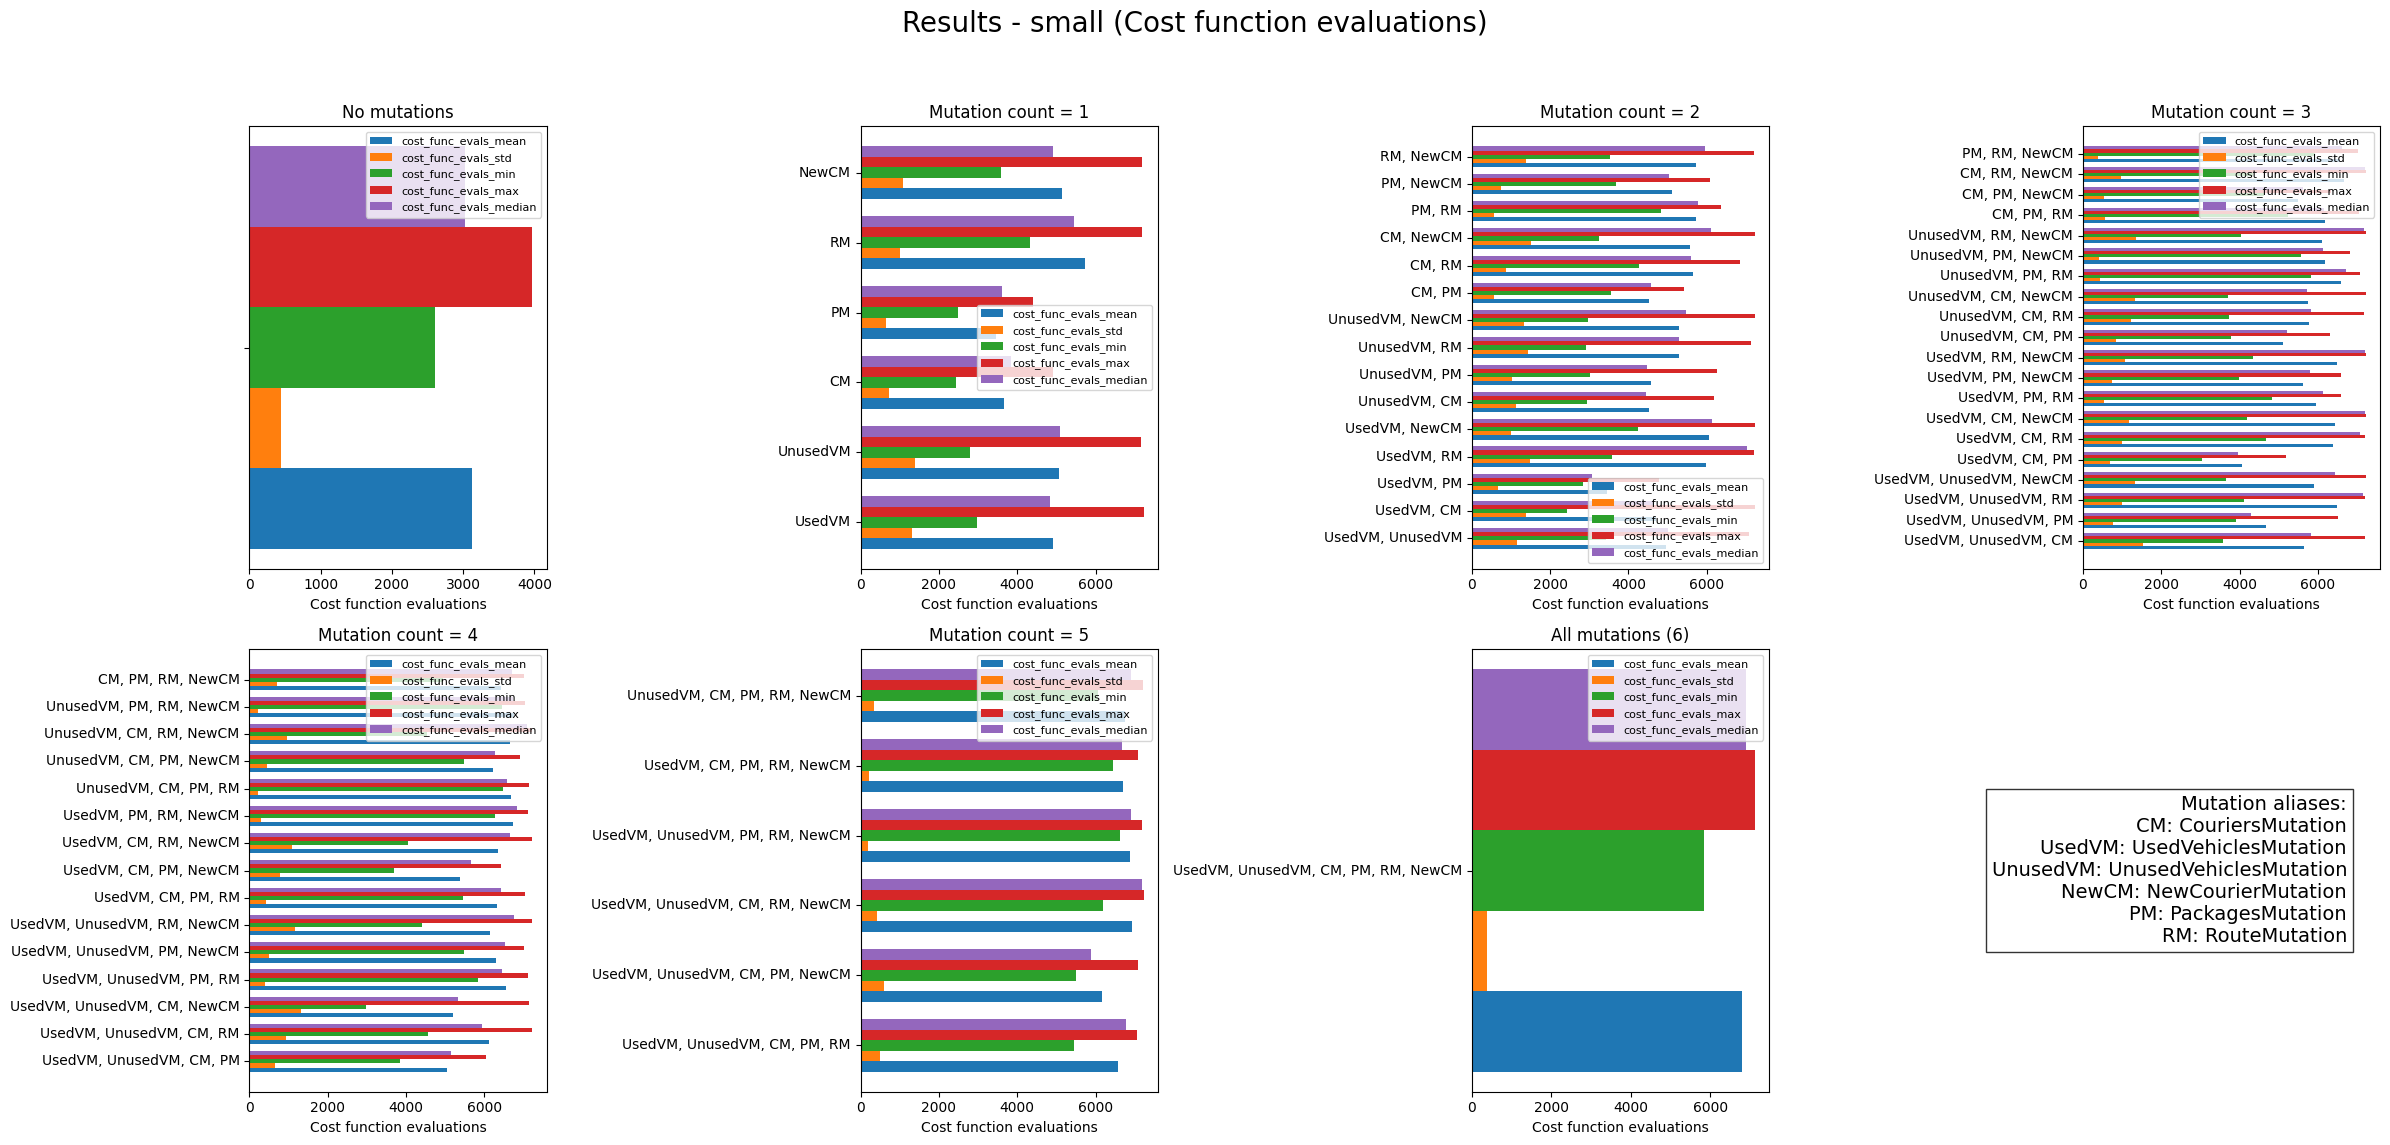

In [43]:
plot_statistics(
    mutation_results_df,
    stat_cols=stat_lists["Cost function evaluations statistics"],
    xlabel="Cost function evaluations",
)

### Plot results for population size testing

In [44]:
population_config = [
    {
        "mean_col": "cost_mean",
        "std_col": "cost_std",
        "min_col": "cost_min",
        "max_col": "cost_max",
        "ylabel": "Cost function value",
        "title": "Cost vs. initial population size",
        "color": "tab:blue",
    },
    {
        "mean_col": "time_mean",
        "std_col": "time_std",
        "min_col": "time_min",
        "max_col": "time_max",
        "ylabel": "Time [s]",
        "title": "Time vs. initial population size",
        "color": "tab:orange",
    },
    {
        "mean_col": "cost_func_evals_mean",
        "std_col": "cost_func_evals_std",
        "min_col": "cost_func_evals_min",
        "max_col": "cost_func_evals_max",
        "ylabel": "Cost function evaluations",
        "title": "Cost function evaluations vs. initial population size",
        "color": "tab:green",
    },
    {
        "mean_col": "iterations_mean",
        "std_col": "iterations_std",
        "min_col": "iterations_min",
        "max_col": "iterations_max",
        "ylabel": "Iterations",
        "title": "Iterations vs. initial population size",
        "color": "tab:red",
    },
]

In [45]:
def plot_population(
    df,
    test_cases=None,
    stats=population_config,
):
    if test_cases is None:
        test_cases = df["testcase"].unique()

    n_stats = len(stats)
    ncols = 2
    nrows = (n_stats + 1) // 2

    for testcase in test_cases:
        subset = df[df["testcase"] == testcase].sort_values("population_size")
        pop_sizes = subset["population_size"]

        fig, axes = plt.subplots(nrows, ncols, figsize=(8 * ncols, 4.5 * nrows))
        fig.suptitle(f"Initial population size impact - {testcase[3:]}", fontsize=20)
        axes = axes.flat if n_stats > 1 else [axes]

        for i, stat in enumerate(stats):
            ax = axes[i]
            mean = subset[stat["mean_col"]]
            std = subset[stat["std_col"]]
            color = stat.get("color", None)
            min_vals = subset[stat.get("min_col")] if stat.get("min_col") else None
            max_vals = subset[stat.get("max_col")] if stat.get("max_col") else None

            # Mean ± std
            ax.errorbar(
                pop_sizes,
                mean,
                yerr=std,
                fmt="-o",
                capsize=5,
                color=color,
                label="mean ± std",
            )
            # Min/max shading
            if min_vals is not None and max_vals is not None:
                ax.fill_between(
                    pop_sizes,
                    min_vals,
                    max_vals,
                    color=color,
                    alpha=0.15,
                    label="min-max range",
                )
                ax.plot(
                    pop_sizes,
                    min_vals,
                    linestyle="--",
                    color=color,
                    alpha=0.6,
                    label="min",
                )
                ax.plot(
                    pop_sizes,
                    max_vals,
                    linestyle="--",
                    color=color,
                    alpha=0.6,
                    label="max",
                )

            ax.set_xlabel("Initial population size", fontsize=13)
            ax.set_ylabel(stat["ylabel"], fontsize=13)
            ax.set_title(stat["title"], fontsize=15)
            ax.grid(True, linestyle="--", alpha=0.5)
            ax.legend(fontsize=10)

        # Hide unused subplots if any
        for j in range(i + 1, nrows * ncols):
            fig.delaxes(axes[j])

        plt.tight_layout(rect=[0, 0.05, 1, 0.95])
        plt.savefig(
            os.path.join(
                population_plots_dir,
                f"{testcase}_population_results.png".lower(),
            ),
            bbox_inches="tight",
        )
        plt.show()

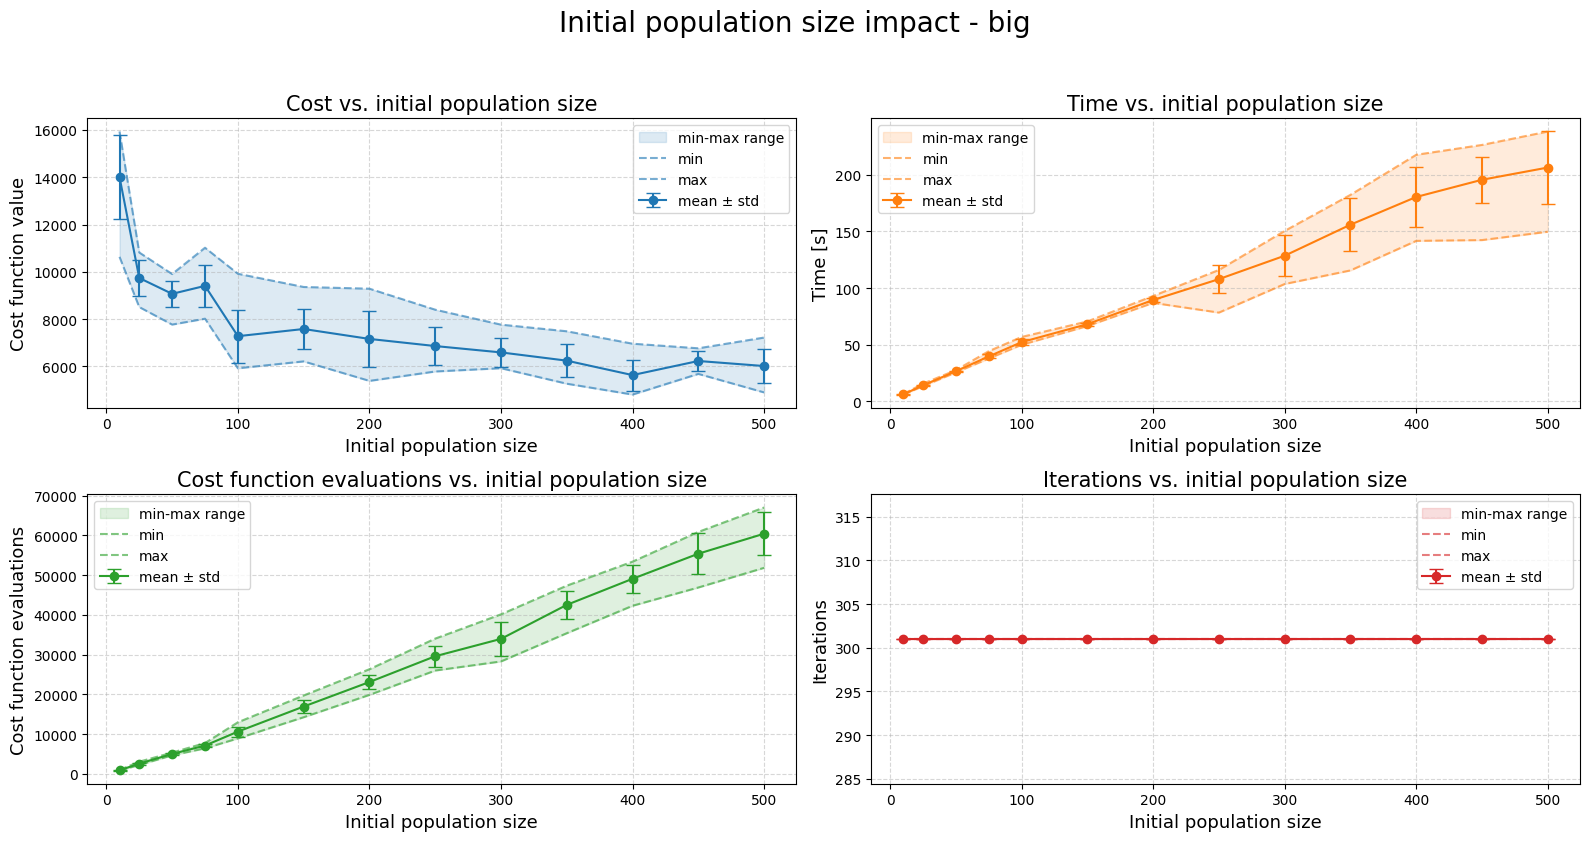

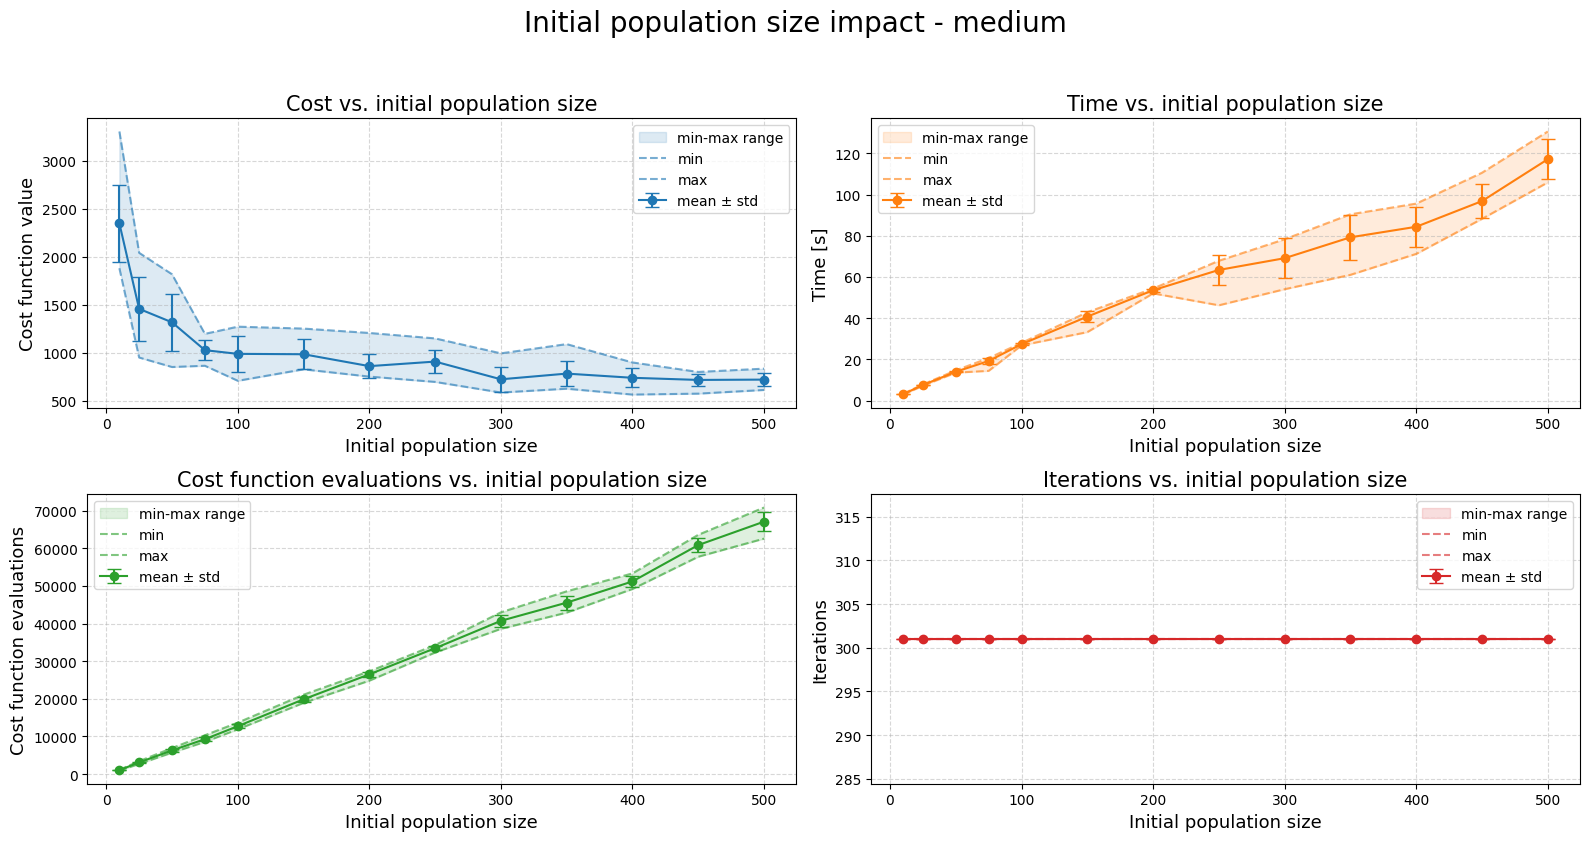

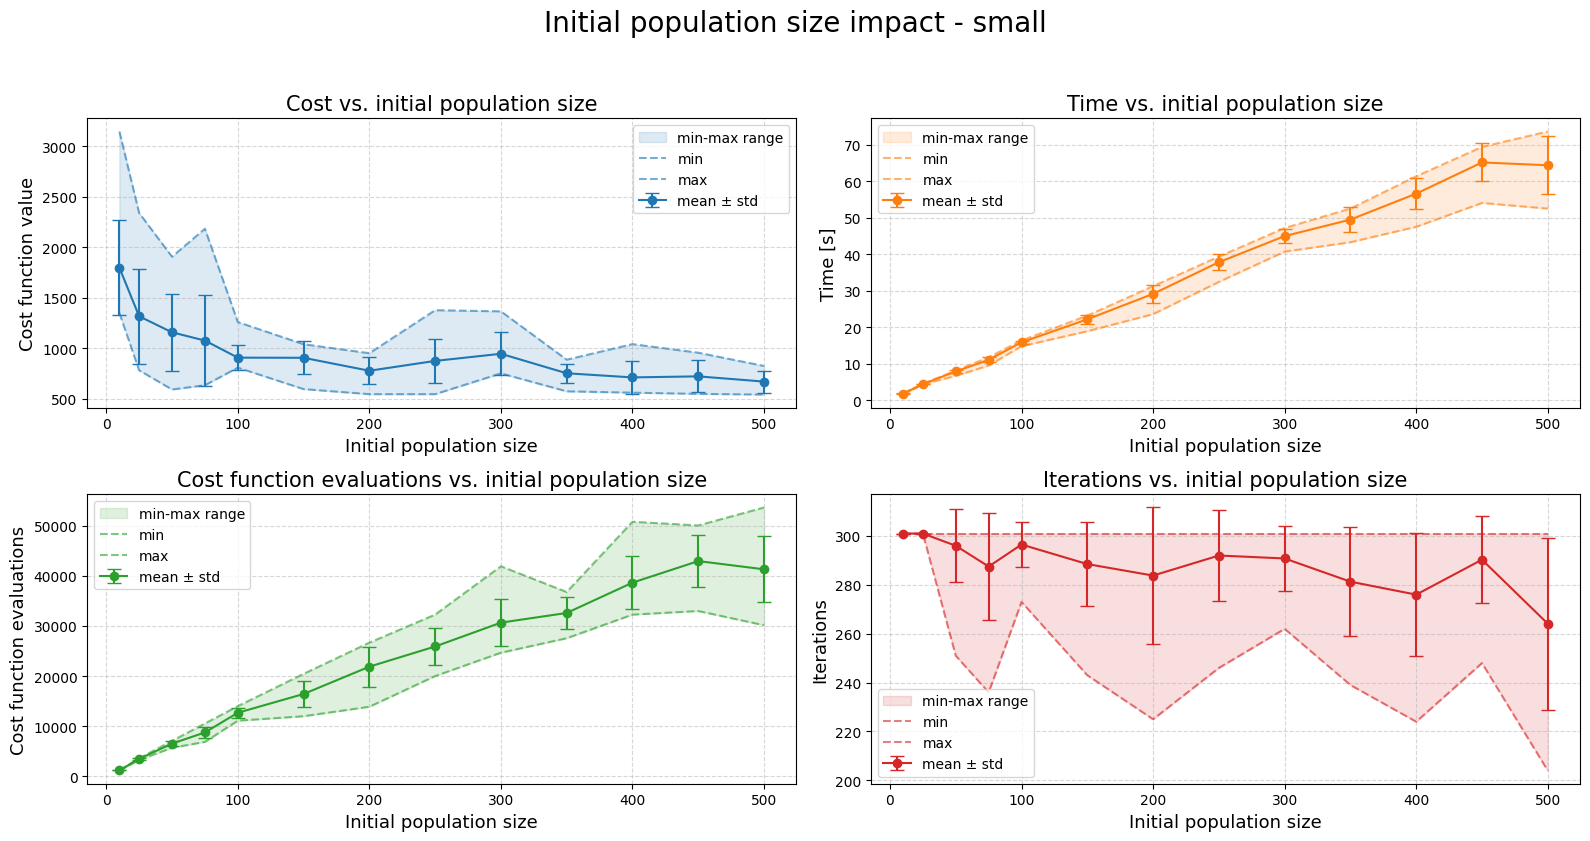

In [46]:
plot_population(population_results_df, test_cases=["03-big", "04-medium", "05-small"])

### Plot results for statistical test

In [47]:
display(stats_df)

UsedVehiclesMutation  UnusedVehiclesMutation  \
UsedVehiclesMutation                     NaN            7.839844e-09   
UnusedVehiclesMutation          7.839844e-09                     NaN   
CouriersMutation                3.442668e-08            5.024681e-05   
PackagesMutation                1.818989e-12            1.818989e-12   
RouteMutation                   1.818989e-12            6.371745e-03   
NewCourierMutation              4.598137e-01            7.880190e-07   

                        CouriersMutation  PackagesMutation  RouteMutation  \
UsedVehiclesMutation        3.442668e-08      1.818989e-12   1.818989e-12   
UnusedVehiclesMutation      5.024681e-05      1.818989e-12   6.371745e-03   
CouriersMutation                     NaN      1.818989e-12   3.563083e-08   
PackagesMutation            1.818989e-12               NaN   1.818989e-12   
RouteMutation               3.563083e-08      1.818989e-12            NaN   
NewCourierMutation          1.140214e-07      1.818989e-12   8.831049e-05   

                        NewCourierMutation  
UsedVehiclesMutation          4.598137e-01  
UnusedVehiclesMutation        7.880190e-07  
CouriersMutation              1.140214e-07  
PackagesMutation              1.818989e-12  
RouteMutation                 8.831049e-05  
NewCourierMutation                     NaN

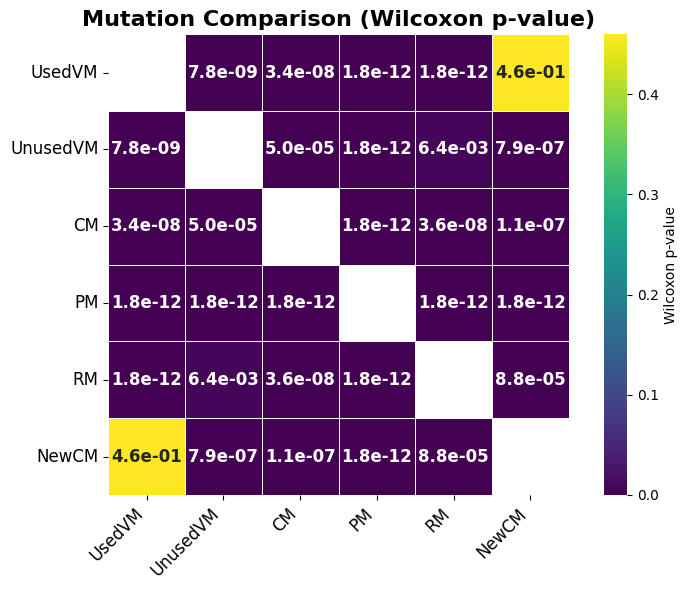

In [57]:
import seaborn as sns

alias_map = {name: alias for name, alias in MUTATION_ALIAS.items()}
stats_df = stats_df.rename(index=alias_map, columns=alias_map)

plt.figure(figsize=(8, 6))
sns.heatmap(
    stats_df,
    annot=True,
    fmt=".1e",
    cmap="viridis",
    mask=np.isnan(stats_df),
    linewidths=0.5,
    linecolor="white",
    cbar_kws={"label": "Wilcoxon p-value"},
    square=True,
    annot_kws={"size": 12, "weight": "bold"},
)
plt.title("Mutation Comparison (Wilcoxon p-value)", fontsize=16, weight="bold")
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.savefig(
    os.path.join(plot_dir, "wilcoxon_heatmap.png"),
    bbox_inches="tight",
)
plt.show()